In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils.attacker import attackDatasetEditDist,changeRandomCharacters
import pandas as pd
import deepmatcher as dm
import numpy as np
from utils.deepmatcher_utils import wrapDm,getF1PrecisionRecall,getMeanConfidenceAndVariance,getTruePositiveNegative
from tqdm import tqdm
from sklearn.utils import shuffle

In [3]:
##given a perturbation model and number of perturbation calculate avg f1,precision and recall 
def getAvgF1PrecisionRecall(testpath,model,nperturbation,editdist=1):
    avgf1,avgrecall,avgprecision = 0,0,0
    for i in tqdm(range(nperturbation)):
        test_df = pd.read_csv(testpath)
        original_labels = test_df.label.values
        attacked_test = attackDatasetEditDist(test_df,['id','label'],editdist=editdist)
        attack_preds = wrapDm(attacked_test,model)
        f1,prec,recall = getF1PrecisionRecall(original_labels,attack_preds)
        avgf1 += f1
        avgprecision += prec
        avgrecall += recall
    return (avgf1/nperturbation,avgprecision/nperturbation,avgrecall/nperturbation)

In [4]:
def getAdversarialTrainingSet(train_df,dimension,editdist):
    shuffled_train = shuffle(train_df)
    samples_toalter = shuffled_train.iloc[:dimension].copy()
    unaltered = shuffled_train.iloc[dimension:].copy()
    attacked_train = attackDatasetEditDist(samples_toalter,['id','label'],editdist=1)
    newTrain = pd.concat([attacked_train,unaltered])
    return newTrain

# Change edit distance

In [5]:
DATASET_DIR='datasets/Structured/itunes-amazon/'

## Evaluate standard model

In [6]:
itunesamazon_mod = dm.MatchingModel(attr_summarizer='hybrid')
itunesamazon_mod.load_state('models/itunes_amazon_hybrid.pth')
itunesamazon_mod = itunesamazon_mod.to('cuda')

In [7]:
avgf1,avgprecision,avgrecall = getAvgF1PrecisionRecall('datasets/Structured/itunes-amazon/merged_test.csv',
                                                       itunesamazon_mod,20,editdist=1)
avgf1,avgprecision,avgrecall

100%|██████████| 20/20 [00:45<00:00,  2.26s/it]


(0.6018780920046372, 0.5742302039727692, 0.6370370370370371)

In [9]:
avgf1,avgprecision,avgrecall = getAvgF1PrecisionRecall('datasets/Structured/itunes-amazon/merged_test.csv',
                                                       itunesamazon_mod,20,editdist=2)
avgf1,avgprecision,avgrecall

100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


(0.5566625559259786, 0.5380849305572994, 0.5814814814814815)

In [8]:
test_df = pd.read_csv('datasets/Structured/itunes-amazon/merged_test.csv')
getMeanConfidenceAndVariance(itunesamazon_mod,test_df)

(0.8026398884457185, 0.014892625030903646)

## Retrain model with 10% perturbed training data

In [9]:
train_df = pd.read_csv(DATASET_DIR+'merged_train.csv')
adversarialTrain_10 = getAdversarialTrainingSet(train_df,int(len(train_df)/10),editdist=1)

In [10]:
adversarialTrain_10.to_csv('datasets/Structured/itunes-amazon/attacked_train10.csv',index=False)

In [11]:
train,validation,test = dm.data.process('datasets/Structured/itunes-amazon/',train='attacked_train10.csv',
                                       validation='merged_valid.csv',test='merged_test.csv',
                                       left_prefix='ltable_',right_prefix='rtable_',cache='editdist.pth')


Reading and processing data from "datasets/Structured/itunes-amazon/attacked_train10.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/itunes-amazon/merged_valid.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/itunes-amazon/merged_test.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [12]:
att_model = dm.MatchingModel(attr_summarizer='hybrid')
att_model.run_train(train,validation,epochs=25,pos_neg_ratio=5,
                    best_save_path='models/itunes_amazon_hybrid_att10.pth')

* Number of trainable parameters: 17757810
===>  TRAIN Epoch 1


/home/nvidia/anaconda3/envs/torchenv/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 1 || Run Time:    4.8 | Load Time:    2.1 || F1:  36.87 | Prec:  23.57 | Rec:  84.62 || Ex/s:  47.03

===>  EVAL Epoch 1
Finished Epoch 1 || Run Time:    0.6 | Load Time:    0.7 || F1:  41.54 | Prec:  26.21 | Rec: 100.00 || Ex/s:  85.24

* Best F1: tensor(41.5385, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 2 || Run Time:    4.8 | Load Time:    2.2 || F1:  41.62 | Prec:  26.37 | Rec:  98.72 || Ex/s:  45.71

===>  EVAL Epoch 2
Finished Epoch 2 || Run Time:    0.6 | Load Time:    0.7 || F1:  57.89 | Prec:  44.90 | Rec:  81.48 || Ex/s:  84.95

* Best F1: tensor(57.8947, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 3 || Run Time:    4.9 | Load Time:    2.2 || F1:  61.67 | Prec:  46.98 | Rec:  89.74 || Ex/s:  45.33

===>  EVAL Epoch 3
Finished Epoch 3 || Run Time:    0.6 | Load Time:    0.7 || F1:  62.69 | Prec:  52.50 | Rec:  77.78 || Ex/s:  84.23

* Best F1: tensor(62.6866, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 4


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 4 || Run Time:    4.9 | Load Time:    2.2 || F1:  66.05 | Prec:  51.82 | Rec:  91.03 || Ex/s:  45.64

===>  EVAL Epoch 4
Finished Epoch 4 || Run Time:    0.6 | Load Time:    0.7 || F1:  68.97 | Prec:  64.52 | Rec:  74.07 || Ex/s:  85.64

* Best F1: tensor(68.9655, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 5


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 5 || Run Time:    4.9 | Load Time:    2.1 || F1:  72.00 | Prec:  59.02 | Rec:  92.31 || Ex/s:  46.45

===>  EVAL Epoch 5
Finished Epoch 5 || Run Time:    0.6 | Load Time:    0.7 || F1:  66.67 | Prec:  58.33 | Rec:  77.78 || Ex/s:  81.93

---------------------

===>  TRAIN Epoch 6


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 6 || Run Time:    4.9 | Load Time:    2.2 || F1:  78.12 | Prec:  65.79 | Rec:  96.15 || Ex/s:  44.91

===>  EVAL Epoch 6
Finished Epoch 6 || Run Time:    0.6 | Load Time:    0.7 || F1:  77.19 | Prec:  73.33 | Rec:  81.48 || Ex/s:  85.99

* Best F1: tensor(77.1930, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 7


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 7 || Run Time:    5.0 | Load Time:    2.3 || F1:  85.39 | Prec:  76.00 | Rec:  97.44 || Ex/s:  44.29

===>  EVAL Epoch 7
Finished Epoch 7 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.33 | Prec:  75.76 | Rec:  92.59 || Ex/s:  86.20

* Best F1: tensor(83.3333, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 8


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 8 || Run Time:    4.9 | Load Time:    2.2 || F1:  93.41 | Prec:  87.64 | Rec: 100.00 || Ex/s:  45.50

===>  EVAL Epoch 8
Finished Epoch 8 || Run Time:    0.6 | Load Time:    0.7 || F1:  85.25 | Prec:  76.47 | Rec:  96.30 || Ex/s:  85.02

* Best F1: tensor(85.2459, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 9


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 9 || Run Time:    4.8 | Load Time:    2.2 || F1:  97.50 | Prec:  95.12 | Rec: 100.00 || Ex/s:  45.76

===>  EVAL Epoch 9
Finished Epoch 9 || Run Time:    0.6 | Load Time:    0.7 || F1:  82.54 | Prec:  72.22 | Rec:  96.30 || Ex/s:  85.33

---------------------

===>  TRAIN Epoch 10


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 10 || Run Time:    4.9 | Load Time:    2.1 || F1:  97.50 | Prec:  95.12 | Rec: 100.00 || Ex/s:  45.78

===>  EVAL Epoch 10
Finished Epoch 10 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  84.53

---------------------

===>  TRAIN Epoch 11


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 11 || Run Time:    4.8 | Load Time:    2.1 || F1:  98.73 | Prec:  97.50 | Rec: 100.00 || Ex/s:  46.00

===>  EVAL Epoch 11
Finished Epoch 11 || Run Time:    0.6 | Load Time:    0.7 || F1:  82.54 | Prec:  72.22 | Rec:  96.30 || Ex/s:  85.29

---------------------

===>  TRAIN Epoch 12


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 12 || Run Time:    4.9 | Load Time:    2.1 || F1:  98.73 | Prec:  97.50 | Rec: 100.00 || Ex/s:  46.26

===>  EVAL Epoch 12
Finished Epoch 12 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  84.00

---------------------

===>  TRAIN Epoch 13


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 13 || Run Time:    4.9 | Load Time:    2.1 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  45.78

===>  EVAL Epoch 13
Finished Epoch 13 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  84.85

---------------------

===>  TRAIN Epoch 14


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 14 || Run Time:    4.4 | Load Time:    1.9 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  50.71

===>  EVAL Epoch 14
Finished Epoch 14 || Run Time:    0.6 | Load Time:    0.6 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  92.17

---------------------

===>  TRAIN Epoch 15


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 15 || Run Time:    4.8 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  46.74

===>  EVAL Epoch 15
Finished Epoch 15 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  84.14

---------------------

===>  TRAIN Epoch 16


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 16 || Run Time:    4.8 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  46.89

===>  EVAL Epoch 16
Finished Epoch 16 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  85.57

---------------------

===>  TRAIN Epoch 17


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 17 || Run Time:    4.7 | Load Time:    2.0 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  47.53

===>  EVAL Epoch 17
Finished Epoch 17 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  85.08

---------------------

===>  TRAIN Epoch 18


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 18 || Run Time:    4.9 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  45.83

===>  EVAL Epoch 18
Finished Epoch 18 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  84.37

---------------------

===>  TRAIN Epoch 19


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 19 || Run Time:    4.8 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  45.98

===>  EVAL Epoch 19
Finished Epoch 19 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  85.03

---------------------

===>  TRAIN Epoch 20


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 20 || Run Time:    4.8 | Load Time:    2.2 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  45.91

===>  EVAL Epoch 20
Finished Epoch 20 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  85.53

---------------------

===>  TRAIN Epoch 21


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 21 || Run Time:    4.9 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  45.63

===>  EVAL Epoch 21
Finished Epoch 21 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  86.66

---------------------

===>  TRAIN Epoch 22


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 22 || Run Time:    4.8 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  47.09

===>  EVAL Epoch 22
Finished Epoch 22 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  86.68

---------------------

===>  TRAIN Epoch 23


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 23 || Run Time:    4.9 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  46.04

===>  EVAL Epoch 23
Finished Epoch 23 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  86.00

---------------------

===>  TRAIN Epoch 24


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 24 || Run Time:    4.6 | Load Time:    1.9 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  49.80

===>  EVAL Epoch 24
Finished Epoch 24 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  85.96

---------------------

===>  TRAIN Epoch 25


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 25 || Run Time:    4.9 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  45.95

===>  EVAL Epoch 25
Finished Epoch 25 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  86.54

---------------------

Loading best model...
Training done.


tensor(85.2459, device='cuda:0')

In [13]:
att_model.run_eval(test)

===>  EVAL Epoch 8
Finished Epoch 8 || Run Time:    0.7 | Load Time:    0.7 || F1:  85.25 | Prec:  76.47 | Rec:  96.30 || Ex/s:  81.09



tensor(85.2459, device='cuda:0')

In [14]:
getMeanConfidenceAndVariance(att_model,test_df)

(0.7836888705235009, 0.016787313181924515)

In [15]:
avgf1,avgprecision,avgrecall = getAvgF1PrecisionRecall('datasets/Structured/itunes-amazon/merged_test.csv',
                                                       att_model,20,editdist=1)
avgf1,avgprecision,avgrecall

100%|██████████| 20/20 [00:34<00:00,  1.73s/it]


(0.6170878502848114, 0.4939288327705847, 0.825925925925926)

In [16]:
avgf1,avgprecision,avgrecall = getAvgF1PrecisionRecall('datasets/Structured/itunes-amazon/merged_test.csv',
                                                       att_model,20,editdist=2)
avgf1,avgprecision,avgrecall

100%|██████████| 20/20 [00:35<00:00,  1.78s/it]


(0.5795080719900618, 0.4545109863934491, 0.8037037037037038)

## Retrain model with 20% perturbed training samples

In [17]:
train_df = pd.read_csv(DATASET_DIR+'merged_train.csv')
adversarialTrain_20 = getAdversarialTrainingSet(train_df,int(len(train_df)/5),editdist=1)

In [18]:
adversarialTrain_20.to_csv(DATASET_DIR+'adversarial_train20.csv',index=False)

In [19]:
train,validation,test = dm.data.process('datasets/Structured/itunes-amazon/',train='adversarial_train20.csv',
                                       validation='merged_valid.csv',test='merged_test.csv',
                                       left_prefix='ltable_',right_prefix='rtable_',cache='editdist.pth')


Reading and processing data from "datasets/Structured/itunes-amazon/adversarial_train20.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/itunes-amazon/merged_valid.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/itunes-amazon/merged_test.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [20]:
att_model2 = dm.MatchingModel(attr_summarizer='hybrid')
att_model2.run_train(train,validation,epochs=25,pos_neg_ratio=5,
                    best_save_path='models/itunes_amazon_hybrid_adversarial20.pth')

* Number of trainable parameters: 17757810
===>  TRAIN Epoch 1


/home/nvidia/anaconda3/envs/torchenv/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 1 || Run Time:    4.7 | Load Time:    2.1 || F1:  39.20 | Prec:  24.38 | Rec: 100.00 || Ex/s:  47.06

===>  EVAL Epoch 1
Finished Epoch 1 || Run Time:    0.6 | Load Time:    0.7 || F1:  49.52 | Prec:  33.33 | Rec:  96.30 || Ex/s:  82.09

* Best F1: tensor(49.5238, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 2 || Run Time:    4.6 | Load Time:    2.0 || F1:  50.17 | Prec:  33.94 | Rec:  96.15 || Ex/s:  48.66

===>  EVAL Epoch 2
Finished Epoch 2 || Run Time:    0.6 | Load Time:    0.6 || F1:  55.56 | Prec:  44.44 | Rec:  74.07 || Ex/s:  90.92

* Best F1: tensor(55.5556, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 3 || Run Time:    4.5 | Load Time:    1.9 || F1:  62.16 | Prec:  47.92 | Rec:  88.46 || Ex/s:  49.80

===>  EVAL Epoch 3
Finished Epoch 3 || Run Time:    0.6 | Load Time:    0.6 || F1:  59.70 | Prec:  50.00 | Rec:  74.07 || Ex/s:  92.08

* Best F1: tensor(59.7015, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 4


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 4 || Run Time:    5.0 | Load Time:    2.2 || F1:  70.59 | Prec:  57.14 | Rec:  92.31 || Ex/s:  44.36

===>  EVAL Epoch 4
Finished Epoch 4 || Run Time:    0.6 | Load Time:    0.7 || F1:  61.54 | Prec:  52.63 | Rec:  74.07 || Ex/s:  84.55

* Best F1: tensor(61.5385, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 5


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 5 || Run Time:    4.7 | Load Time:    2.0 || F1:  73.00 | Prec:  59.84 | Rec:  93.59 || Ex/s:  48.31

===>  EVAL Epoch 5
Finished Epoch 5 || Run Time:    0.6 | Load Time:    0.7 || F1:  66.67 | Prec:  60.61 | Rec:  74.07 || Ex/s:  85.20

* Best F1: tensor(66.6667, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 6


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 6 || Run Time:    4.9 | Load Time:    2.2 || F1:  75.26 | Prec:  62.93 | Rec:  93.59 || Ex/s:  44.95

===>  EVAL Epoch 6
Finished Epoch 6 || Run Time:    0.7 | Load Time:    0.7 || F1:  72.41 | Prec:  67.74 | Rec:  77.78 || Ex/s:  81.44

* Best F1: tensor(72.4138, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 7


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 7 || Run Time:    4.6 | Load Time:    2.0 || F1:  81.72 | Prec:  70.37 | Rec:  97.44 || Ex/s:  48.69

===>  EVAL Epoch 7
Finished Epoch 7 || Run Time:    0.6 | Load Time:    0.7 || F1:  76.36 | Prec:  75.00 | Rec:  77.78 || Ex/s:  84.80

* Best F1: tensor(76.3636, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 8


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 8 || Run Time:    4.7 | Load Time:    2.2 || F1:  88.51 | Prec:  80.21 | Rec:  98.72 || Ex/s:  46.44

===>  EVAL Epoch 8
Finished Epoch 8 || Run Time:    0.6 | Load Time:    0.6 || F1:  80.70 | Prec:  76.67 | Rec:  85.19 || Ex/s:  94.01

* Best F1: tensor(80.7018, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 9


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 9 || Run Time:    4.4 | Load Time:    1.9 || F1:  94.55 | Prec:  89.66 | Rec: 100.00 || Ex/s:  50.78

===>  EVAL Epoch 9
Finished Epoch 9 || Run Time:    0.6 | Load Time:    0.6 || F1:  82.14 | Prec:  79.31 | Rec:  85.19 || Ex/s:  92.71

* Best F1: tensor(82.1429, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 10


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 10 || Run Time:    4.4 | Load Time:    1.9 || F1:  96.30 | Prec:  92.86 | Rec: 100.00 || Ex/s:  50.46

===>  EVAL Epoch 10
Finished Epoch 10 || Run Time:    0.6 | Load Time:    0.6 || F1:  83.64 | Prec:  82.14 | Rec:  85.19 || Ex/s:  94.93

* Best F1: tensor(83.6364, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 11


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 11 || Run Time:    4.5 | Load Time:    1.9 || F1:  98.11 | Prec:  96.30 | Rec: 100.00 || Ex/s:  50.30

===>  EVAL Epoch 11
Finished Epoch 11 || Run Time:    0.6 | Load Time:    0.6 || F1:  83.64 | Prec:  82.14 | Rec:  85.19 || Ex/s:  91.34

---------------------

===>  TRAIN Epoch 12


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 12 || Run Time:    4.5 | Load Time:    2.0 || F1:  97.50 | Prec:  95.12 | Rec: 100.00 || Ex/s:  49.36

===>  EVAL Epoch 12
Finished Epoch 12 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.64 | Prec:  82.14 | Rec:  85.19 || Ex/s:  85.46

---------------------

===>  TRAIN Epoch 13


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 13 || Run Time:    4.5 | Load Time:    1.9 || F1:  98.11 | Prec:  96.30 | Rec: 100.00 || Ex/s:  50.27

===>  EVAL Epoch 13
Finished Epoch 13 || Run Time:    0.6 | Load Time:    0.6 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  91.94

* Best F1: tensor(85.1852, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 14


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 14 || Run Time:    4.4 | Load Time:    1.9 || F1:  98.73 | Prec:  97.50 | Rec: 100.00 || Ex/s:  50.61

===>  EVAL Epoch 14
Finished Epoch 14 || Run Time:    0.6 | Load Time:    0.6 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  92.29

---------------------

===>  TRAIN Epoch 15


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 15 || Run Time:    4.6 | Load Time:    1.9 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  49.07

===>  EVAL Epoch 15
Finished Epoch 15 || Run Time:    0.6 | Load Time:    0.7 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  85.39

---------------------

===>  TRAIN Epoch 16


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 16 || Run Time:    4.5 | Load Time:    1.9 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  49.85

===>  EVAL Epoch 16
Finished Epoch 16 || Run Time:    0.6 | Load Time:    0.6 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  90.39

---------------------

===>  TRAIN Epoch 17


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 17 || Run Time:    4.7 | Load Time:    2.0 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  48.25

===>  EVAL Epoch 17
Finished Epoch 17 || Run Time:    0.6 | Load Time:    0.7 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  84.58

---------------------

===>  TRAIN Epoch 18


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 18 || Run Time:    4.9 | Load Time:    2.1 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  45.93

===>  EVAL Epoch 18
Finished Epoch 18 || Run Time:    0.6 | Load Time:    0.7 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  82.82

---------------------

===>  TRAIN Epoch 19


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 19 || Run Time:    4.6 | Load Time:    2.0 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  48.71

===>  EVAL Epoch 19
Finished Epoch 19 || Run Time:    0.6 | Load Time:    0.6 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  87.91

---------------------

===>  TRAIN Epoch 20


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 20 || Run Time:    4.7 | Load Time:    2.0 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  47.68

===>  EVAL Epoch 20
Finished Epoch 20 || Run Time:    0.6 | Load Time:    0.7 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  83.28

---------------------

===>  TRAIN Epoch 21


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 21 || Run Time:    4.7 | Load Time:    2.0 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  48.09

===>  EVAL Epoch 21
Finished Epoch 21 || Run Time:    0.6 | Load Time:    0.6 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  89.69

---------------------

===>  TRAIN Epoch 22


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 22 || Run Time:    4.7 | Load Time:    2.0 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  48.03

===>  EVAL Epoch 22
Finished Epoch 22 || Run Time:    0.7 | Load Time:    0.7 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  82.27

---------------------

===>  TRAIN Epoch 23


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 23 || Run Time:    4.7 | Load Time:    2.0 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  47.41

===>  EVAL Epoch 23
Finished Epoch 23 || Run Time:    0.6 | Load Time:    0.7 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  83.07

---------------------

===>  TRAIN Epoch 24


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 24 || Run Time:    4.7 | Load Time:    2.0 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  47.70

===>  EVAL Epoch 24
Finished Epoch 24 || Run Time:    0.6 | Load Time:    0.7 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  82.40

---------------------

===>  TRAIN Epoch 25


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 25 || Run Time:    4.7 | Load Time:    2.0 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  47.95

===>  EVAL Epoch 25
Finished Epoch 25 || Run Time:    0.6 | Load Time:    0.7 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  82.66

---------------------

Loading best model...
Training done.


tensor(85.1852, device='cuda:0')

In [21]:
att_model2.run_eval(test)

===>  EVAL Epoch 13
Finished Epoch 13 || Run Time:    0.7 | Load Time:    0.7 || F1:  84.00 | Prec:  91.30 | Rec:  77.78 || Ex/s:  80.33



tensor(84., device='cuda:0')

In [22]:
getMeanConfidenceAndVariance(att_model,test_df)

(0.7836888705235009, 0.016787313181924515)

In [24]:
avgf1,avgprecision,avgrecall = getAvgF1PrecisionRecall('datasets/Structured/itunes-amazon/merged_test.csv',
                                                       att_model2,20,editdist=1)
avgf1,avgprecision,avgrecall

100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


(0.6372940167985787, 0.5283647337019737, 0.8074074074074075)

In [36]:
avgf1,avgprecision,avgrecall = getAvgF1PrecisionRecall('datasets/Structured/itunes-amazon/merged_test.csv',
                                                       att_model,20,editdist=2)
avgf1,avgprecision,avgrecall

100%|██████████| 20/20 [00:31<00:00,  1.55s/it]


(0.5977356035542621, 0.4743214801476393, 0.8111111111111112)

## Retrain with 33% perturbed tra

In [26]:
train_df = pd.read_csv(DATASET_DIR+'merged_train.csv')
adversarialTrain_30 = getAdversarialTrainingSet(train_df,int(len(train_df)/3),editdist=1)

In [28]:
adversarialTrain_30.to_csv(DATASET_DIR+'adversarial_train30.csv',index=False)

In [29]:
train,validation,test = dm.data.process('datasets/Structured/itunes-amazon/',train='adversarial_train30.csv',
                                       validation='merged_valid.csv',test='merged_test.csv',
                                       left_prefix='ltable_',right_prefix='rtable_',cache='editdist.pth')


Reading and processing data from "datasets/Structured/itunes-amazon/adversarial_train30.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/itunes-amazon/merged_valid.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/itunes-amazon/merged_test.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [31]:
att_model3 = dm.MatchingModel(attr_summarizer='hybrid')
att_model3.run_train(train,validation,epochs=30,pos_neg_ratio=5,batch_size=16,
                    best_save_path='models/itunes_amazon_hybrid_adversarial30.pth')

* Number of trainable parameters: 17757810
===>  TRAIN Epoch 1


/home/nvidia/anaconda3/envs/torchenv/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 1 || Run Time:    9.1 | Load Time:    2.1 || F1:  39.39 | Prec:  24.53 | Rec: 100.00 || Ex/s:  28.64

===>  EVAL Epoch 1


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 1 || Run Time:    1.1 | Load Time:    0.6 || F1:  49.06 | Prec:  32.91 | Rec:  96.30 || Ex/s:  64.06

* Best F1: tensor(49.0566, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 2 || Run Time:    9.1 | Load Time:    2.0 || F1:  57.83 | Prec:  42.11 | Rec:  92.31 || Ex/s:  28.78

===>  EVAL Epoch 2


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 2 || Run Time:    1.1 | Load Time:    0.6 || F1:  55.42 | Prec:  41.07 | Rec:  85.19 || Ex/s:  63.25

* Best F1: tensor(55.4217, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 3 || Run Time:    9.4 | Load Time:    2.2 || F1:  68.60 | Prec:  55.04 | Rec:  91.03 || Ex/s:  27.70

===>  EVAL Epoch 3


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 3 || Run Time:    1.1 | Load Time:    0.6 || F1:  62.69 | Prec:  52.50 | Rec:  77.78 || Ex/s:  62.67

* Best F1: tensor(62.6866, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 4


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 4 || Run Time:    9.6 | Load Time:    2.2 || F1:  75.90 | Prec:  63.25 | Rec:  94.87 || Ex/s:  27.26

===>  EVAL Epoch 4


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 4 || Run Time:    1.1 | Load Time:    0.6 || F1:  64.86 | Prec:  51.06 | Rec:  88.89 || Ex/s:  63.36

* Best F1: tensor(64.8649, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 5


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 5 || Run Time:    9.6 | Load Time:    2.2 || F1:  79.17 | Prec:  66.67 | Rec:  97.44 || Ex/s:  27.21

===>  EVAL Epoch 5


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 5 || Run Time:    1.1 | Load Time:    0.6 || F1:  69.44 | Prec:  55.56 | Rec:  92.59 || Ex/s:  64.20

* Best F1: tensor(69.4444, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 6


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 6 || Run Time:    9.6 | Load Time:    2.2 || F1:  86.19 | Prec:  75.73 | Rec: 100.00 || Ex/s:  27.27

===>  EVAL Epoch 6


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 6 || Run Time:    1.1 | Load Time:    0.6 || F1:  67.65 | Prec:  56.10 | Rec:  85.19 || Ex/s:  63.21

---------------------

===>  TRAIN Epoch 7


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 7 || Run Time:    9.4 | Load Time:    2.1 || F1:  91.23 | Prec:  83.87 | Rec: 100.00 || Ex/s:  27.87

===>  EVAL Epoch 7


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 7 || Run Time:    1.1 | Load Time:    0.6 || F1:  74.19 | Prec:  65.71 | Rec:  85.19 || Ex/s:  63.68

* Best F1: tensor(74.1936, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 8


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 8 || Run Time:    9.6 | Load Time:    2.2 || F1:  96.89 | Prec:  93.98 | Rec: 100.00 || Ex/s:  27.27

===>  EVAL Epoch 8


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 8 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  63.66

* Best F1: tensor(76.1905, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 9


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 9 || Run Time:    9.5 | Load Time:    2.2 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  27.45

===>  EVAL Epoch 9


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 9 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  63.72

---------------------

===>  TRAIN Epoch 10


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 10 || Run Time:    9.5 | Load Time:    2.1 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  27.47

===>  EVAL Epoch 10


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 10 || Run Time:    1.1 | Load Time:    0.6 || F1:  77.42 | Prec:  68.57 | Rec:  88.89 || Ex/s:  65.36

* Best F1: tensor(77.4194, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 11


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 11 || Run Time:    9.5 | Load Time:    2.2 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  27.46

===>  EVAL Epoch 11


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 11 || Run Time:    1.1 | Load Time:    0.6 || F1:  75.41 | Prec:  67.65 | Rec:  85.19 || Ex/s:  64.73

---------------------

===>  TRAIN Epoch 12


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 12 || Run Time:    9.5 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  27.57

===>  EVAL Epoch 12


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 12 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  65.50

---------------------

===>  TRAIN Epoch 13


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 13 || Run Time:    9.4 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  27.89

===>  EVAL Epoch 13


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 13 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  65.28

---------------------

===>  TRAIN Epoch 14


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 14 || Run Time:    9.4 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  27.78

===>  EVAL Epoch 14


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 14 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  65.63

---------------------

===>  TRAIN Epoch 15


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 15 || Run Time:    9.3 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.13

===>  EVAL Epoch 15


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 15 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  64.28

---------------------

===>  TRAIN Epoch 16


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 16 || Run Time:    9.5 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  27.88

===>  EVAL Epoch 16


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 16 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  65.75

---------------------

===>  TRAIN Epoch 17


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 17 || Run Time:    9.4 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.00

===>  EVAL Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 17 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  64.88

---------------------

===>  TRAIN Epoch 18


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 18 || Run Time:    9.5 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  27.51

===>  EVAL Epoch 18


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 18 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  64.65

---------------------

===>  TRAIN Epoch 19


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 19 || Run Time:    9.5 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  27.69

===>  EVAL Epoch 19


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 19 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  65.04

---------------------

===>  TRAIN Epoch 20


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 20 || Run Time:    9.4 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.02

===>  EVAL Epoch 20


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 20 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  64.21

---------------------

===>  TRAIN Epoch 21


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 21 || Run Time:    9.4 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  27.76

===>  EVAL Epoch 21


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 21 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  64.58

---------------------

===>  TRAIN Epoch 22


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 22 || Run Time:    9.4 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.02

===>  EVAL Epoch 22


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 22 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  65.15

---------------------

===>  TRAIN Epoch 23


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 23 || Run Time:    9.4 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  27.84

===>  EVAL Epoch 23


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 23 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  64.33

---------------------

===>  TRAIN Epoch 24


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 24 || Run Time:    9.5 | Load Time:    2.2 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  27.54

===>  EVAL Epoch 24


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 24 || Run Time:    1.0 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  66.60

---------------------

===>  TRAIN Epoch 25


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 25 || Run Time:    8.7 | Load Time:    1.9 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  30.25

===>  EVAL Epoch 25


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 25 || Run Time:    1.0 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  70.93

---------------------

===>  TRAIN Epoch 26


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 26 || Run Time:    8.5 | Load Time:    1.8 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  30.88

===>  EVAL Epoch 26


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 26 || Run Time:    1.0 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  67.09

---------------------

===>  TRAIN Epoch 27


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 27 || Run Time:    8.3 | Load Time:    1.7 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  32.12

===>  EVAL Epoch 27


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 27 || Run Time:    1.0 | Load Time:    0.5 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  72.03

---------------------

===>  TRAIN Epoch 28


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 28 || Run Time:    8.5 | Load Time:    1.8 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  31.08

===>  EVAL Epoch 28


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 28 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  64.97

---------------------

===>  TRAIN Epoch 29


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 29 || Run Time:    8.5 | Load Time:    1.8 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  31.09

===>  EVAL Epoch 29


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 29 || Run Time:    1.0 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  68.79

---------------------

===>  TRAIN Epoch 30


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 30 || Run Time:    8.8 | Load Time:    1.9 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.89

===>  EVAL Epoch 30


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 30 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  65.61

---------------------

Loading best model...
Training done.


tensor(77.4194, device='cuda:0')

In [32]:
att_model3.run_eval(test)

===>  EVAL Epoch 10
Finished Epoch 10 || Run Time:    0.6 | Load Time:    0.7 || F1:  81.97 | Prec:  73.53 | Rec:  92.59 || Ex/s:  84.46



tensor(81.9672, device='cuda:0')

In [ ]:
avgf1,avgprecision,avgrecall = getAvgF1PrecisionRecall('datasets/Structured/itunes-amazon/merged_test.csv',
                                                       att_model3,20,editdist=1)
avgf1,avgprecision,avgrecall

 50%|█████     | 10/20 [00:17<00:17,  1.74s/it]

# Evaluate rankings with triangles

## StandardModel

In [6]:
from utils.dataset_parser import getFullDataset,generate_train_valid_test
from utils.explainer import Explainer
from utils.mojito2 import aggregateRankings

In [7]:
itunes_model = dm.MatchingModel(attr_summarizer='hybrid')
itunes_model.load_state('models/itunes_amazon_hybrid.pth')
itunes_model = itunes_model.to('cuda')

In [8]:
explainer_standard = Explainer(itunes_model,[])

In [9]:
ITUNES_DIR ='datasets/Structured/itunes-amazon/'

In [17]:
neg_rankings_itunes0,flipped_neg0 = explainer_standard.getRankingsBlackBox(ITUNES_DIR,'augmented_test.csv',
                                                                           0,1,augment_test=True)



  0%|          | 0/52 [00:00<?, ?it/s]

  2%|▏         | 1/52 [00:01<01:00,  1.18s/it]

  4%|▍         | 2/52 [00:02<00:58,  1.18s/it]

  6%|▌         | 3/52 [00:03<00:57,  1.18s/it]

  8%|▊         | 4/52 [00:04<00:56,  1.18s/it]

 10%|▉         | 5/52 [00:05<00:55,  1.19s/it]

 12%|█▏        | 6/52 [00:07<00:54,  1.19s/it]

 13%|█▎        | 7/52 [00:08<00:53,  1.20s/it]

 15%|█▌        | 8/52 [00:09<00:52,  1.19s/it]

 17%|█▋        | 9/52 [00:10<00:51,  1.19s/it]

 19%|█▉        | 10/52 [00:11<00:49,  1.19s/it]

 21%|██        | 11/52 [00:13<00:49,  1.21s/it]

 23%|██▎       | 12/52 [00:14<00:48,  1.21s/it]

 25%|██▌       | 13/52 [00:15<00:46,  1.20s/it]

 27%|██▋       | 14/52 [00:16<00:45,  1.19s/it]

 29%|██▉       | 15/52 [00:17<00:44,  1.19s/it]

 31%|███       | 16/52 [00:19<00:42,  1.19s/it]

 33%|███▎      | 17/52 [00:20<00:42,  1.21s/it]

 35%|███▍      | 18/52 [00:21<00:40,  1.20s/it]

 37%|███▋      | 19/52 [00:22<00:39,  1.19s/it]

 38%|███▊      | 20/52 [00:23<00:38,

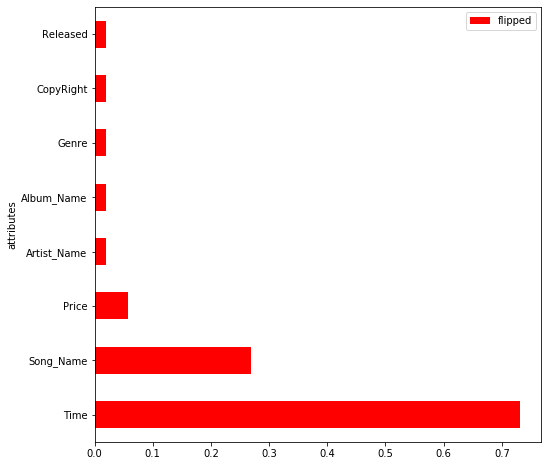

In [32]:
ax,negRank0 = aggregateRankings(neg_rankings_itunes0,positive=False,maxLenAttributes=1,lenTriangles=52)

In [27]:
pos_rankings_itunes0,flipped_pos0 = explainer_standard.getRankingsBlackBox(ITUNES_DIR,'augmented_test.csv',
                                                                                          1,1,augment_test=True)



  0%|          | 0/52 [00:00<?, ?it/s]

  2%|▏         | 1/52 [00:01<01:08,  1.35s/it]

  4%|▍         | 2/52 [00:02<01:07,  1.35s/it]

  6%|▌         | 3/52 [00:04<01:05,  1.34s/it]

  8%|▊         | 4/52 [00:05<01:04,  1.34s/it]

 10%|▉         | 5/52 [00:06<01:03,  1.34s/it]

 12%|█▏        | 6/52 [00:08<01:02,  1.36s/it]

 13%|█▎        | 7/52 [00:09<01:01,  1.36s/it]

 15%|█▌        | 8/52 [00:10<00:59,  1.36s/it]

 17%|█▋        | 9/52 [00:12<00:59,  1.39s/it]

 19%|█▉        | 10/52 [00:13<00:58,  1.38s/it]

 21%|██        | 11/52 [00:15<00:56,  1.38s/it]

 23%|██▎       | 12/52 [00:16<00:55,  1.39s/it]

 25%|██▌       | 13/52 [00:17<00:53,  1.38s/it]

 27%|██▋       | 14/52 [00:19<00:52,  1.38s/it]

 29%|██▉       | 15/52 [00:20<00:50,  1.37s/it]

 31%|███       | 16/52 [00:21<00:49,  1.37s/it]

 33%|███▎      | 17/52 [00:23<00:48,  1.39s/it]

 35%|███▍      | 18/52 [00:24<00:47,  1.39s/it]

 37%|███▋      | 19/52 [00:26<00:45,  1.39s/it]

 38%|███▊      | 20/52 [00:27<00:44,

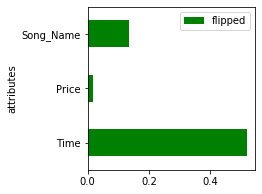

In [30]:
ax,posRank0 = aggregateRankings(pos_rankings_itunes0,positive=True,maxLenAttributes=1,lenTriangles=52)

## Prepare new Training data

In [130]:
augmented_train = prepareDataset(train_df,tableA_itunes,tableB_itunes,50)
augmented_train.to_csv(ITUNES_DIR+'augmented_train.csv',index=False)
len(train_df),len(augmented_train)

(321, 349)

In [131]:
trainPreds = getTruePositiveNegative(itunesamazon_mod,augmented_train,ignore_columns=['id','ltable_id',
                                                                                     'rtable_id','label'])

In [132]:
neg_rankings_itunes,neg_triangles_itunes,flippedPredictions_neg = explainSamples(trainPreds,
                                                          [tableA_itunes,tableB_itunes],
                                                          itunesamazon_mod,originalClass=0)


100%|██████████| 150/150 [05:45<00:00,  2.30s/it]


In [133]:
pos_rankings_itunes,pos_triangles_itunes,flippedPredictions_pos = explainSamples(trainPreds,
                                                          [tableA_itunes,tableB_itunes],
                                                          itunesamazon_mod,originalClass=1)


100%|██████████| 150/150 [05:41<00:00,  2.27s/it]


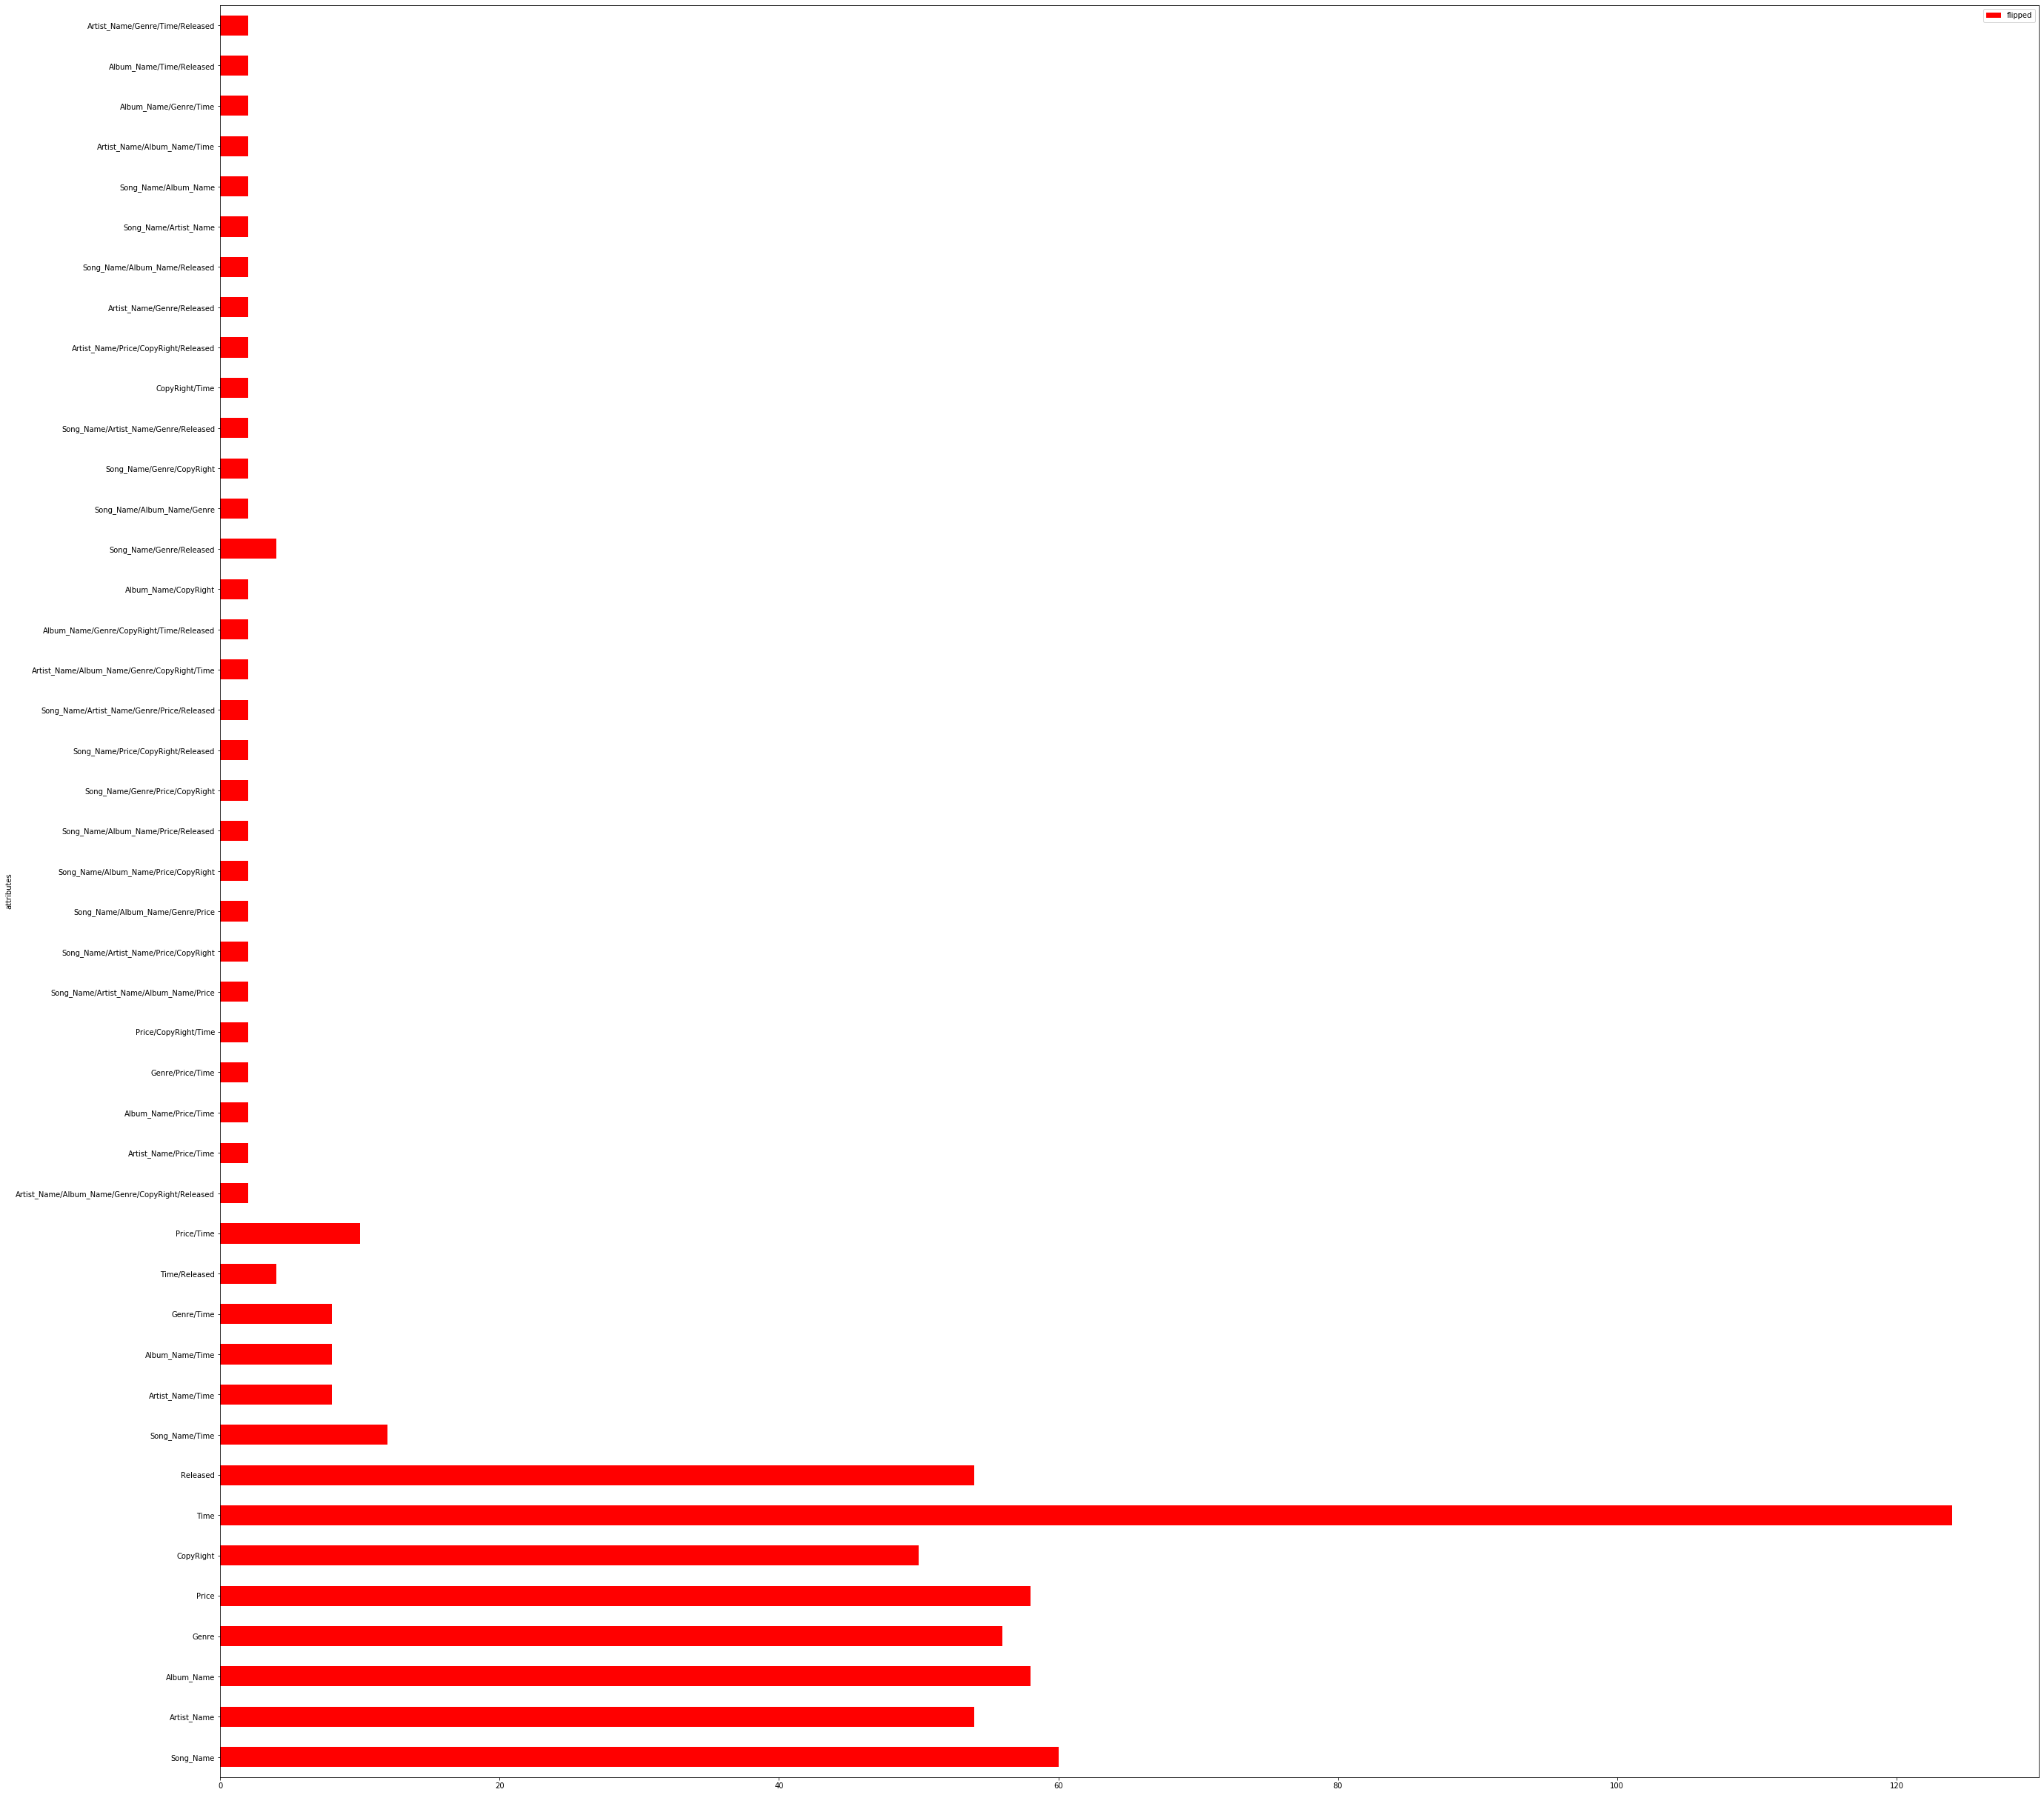

In [22]:
aggregateRankings(neg_rankings_itunes,positive=False)

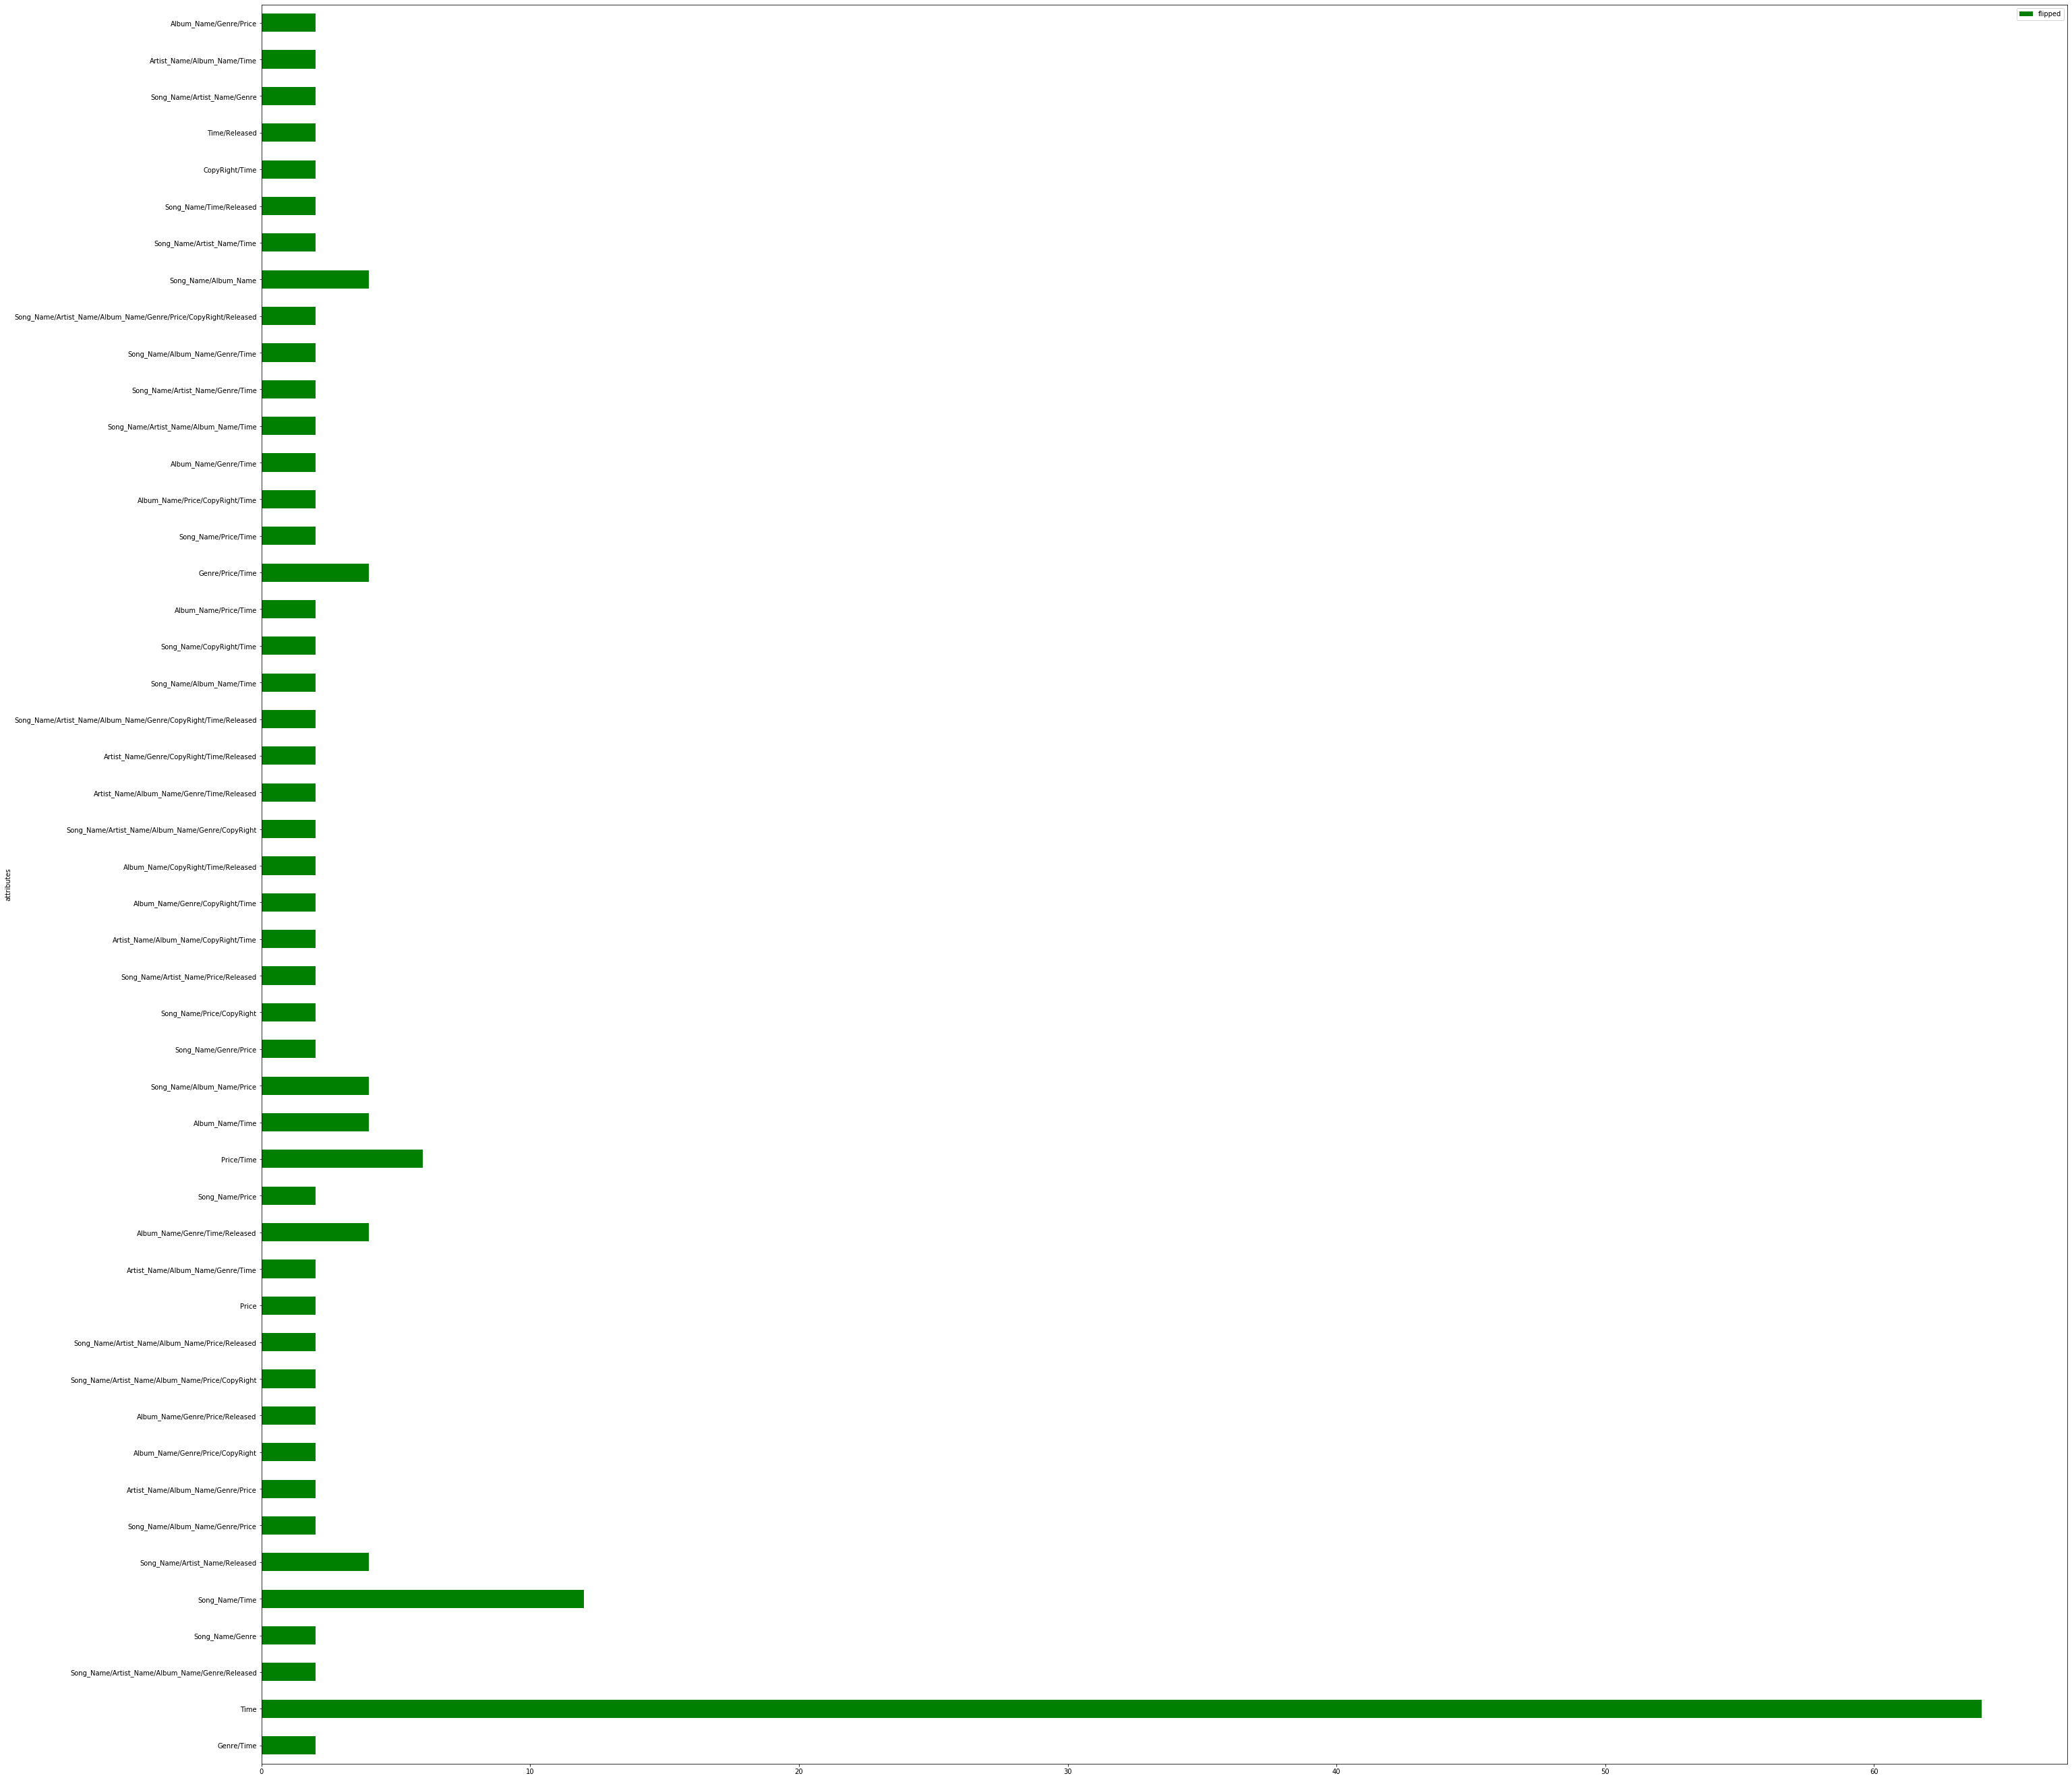

In [23]:
aggregateRankings(pos_rankings_itunes,positive=True)

In [24]:
newTrain_Pos = flippedPredictions_pos[(flippedPredictions_pos.alteredAttribute==('Time',))|
                                     (flippedPredictions_pos.alteredAttribute==('Price','Time'))|
                                     (flippedPredictions_pos.alteredAttribute==('Genre','Price','Time'))].sample(n=30)

In [134]:
newTrain_Pos2 = flippedPredictions_pos[(flippedPredictions_pos.alteredAttribute==('Time',))|
                                     (flippedPredictions_pos.alteredAttribute==('Price','Time'))|
                                     (flippedPredictions_pos.alteredAttribute==('Genre','Price','Time'))].sample(n=40)

In [26]:
newTrain_neg = flippedPredictions_neg[(flippedPredictions_neg.alteredAttribute==('Time'))|
                                     (flippedPredictions_neg.alteredAttribute==('Price','Time'))|
                                     (flippedPredictions_neg.alteredAttribute==('CopyRight'))].sample(n=50)

In [135]:
newTrain_neg2 = flippedPredictions_neg[(flippedPredictions_neg.alteredAttribute==('Time'))|
                                     (flippedPredictions_neg.alteredAttribute==('Price','Time'))|
                                     (flippedPredictions_neg.alteredAttribute==('CopyRight'))|
                                      (flippedPredictions_neg.alteredAttribute==('Released'))].sample(n=75)

In [31]:
newTrain_Pos['label'] = 1
newTrain_neg['label'] = 0
newTraining = pd.concat([newTrain_Pos,newTrain_neg])

In [137]:
newTrain_Pos2['label'] = 1
newTrain_neg2['label'] = 0
newTraining2 = pd.concat([newTrain_Pos2,newTrain_neg2])
orderedCols = list(train_df)
newTraining2 = newTraining2.drop(columns=['alteredAttribute'],axis=1)
newTraining2 = newTraining2[orderedCols]
improvedTrain2 = pd.concat([train_df,newTraining2])

In [32]:
orderedCols = list(train_df)
newTraining = newTraining.drop(columns=['alteredAttribute'],axis=1)
newTraining = newTraining[orderedCols]
improvedTrain = pd.concat([train_df,newTraining])

In [67]:
import numpy as np 
improvedTrain['id'] = np.arange(len(improvedTrain)) 

In [68]:
improvedTrain.to_csv(ITUNES_DIR+'improvedTrain1.csv',index=False)
len(improvedTrain),len(train_df)

(401, 321)

In [138]:
improvedTrain2.to_csv(ITUNES_DIR+'improvedTrain2.csv',index=False)
len(improvedTrain2)

436

## Retrain

In [74]:
train,validation,test = dm.data.process(ITUNES_DIR,train='improvedTrain1.csv',validation='valid_withid.csv',
                                       test='test_withid.csv',left_prefix='ltable_',right_prefix='rtable_',
                                        cache='impr.pth',ignore_columns=['ltable_id','rtable_id'])


Reading and processing data from "datasets/Structured/itunes-amazon/improvedTrain1.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/itunes-amazon/valid_withid.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/itunes-amazon/test_withid.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [75]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.run_train(train,validation,pos_neg_ratio=5,
                      batch_size=16,epochs=25,best_save_path='itunesamazon_impr.pth')

* Number of trainable parameters: 17757810
===>  TRAIN Epoch 1


/home/nvidia/anaconda3/envs/torchenv/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 1 || Run Time:   11.0 | Load Time:    2.2 || F1:  44.71 | Prec:  29.97 | Rec:  87.96 || Ex/s:  30.40

===>  EVAL Epoch 1


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 1 || Run Time:    1.0 | Load Time:    0.5 || F1:  54.74 | Prec:  38.24 | Rec:  96.30 || Ex/s:  73.57

* Best F1: tensor(54.7368, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 2 || Run Time:   11.7 | Load Time:    2.4 || F1:  54.79 | Prec:  38.91 | Rec:  92.59 || Ex/s:  28.56

===>  EVAL Epoch 2


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 2 || Run Time:    1.0 | Load Time:    0.5 || F1:  65.00 | Prec:  49.06 | Rec:  96.30 || Ex/s:  72.26

* Best F1: tensor(65., device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 3 || Run Time:   11.3 | Load Time:    2.3 || F1:  66.46 | Prec:  50.24 | Rec:  98.15 || Ex/s:  29.40

===>  EVAL Epoch 3


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 3 || Run Time:    1.0 | Load Time:    0.5 || F1:  72.22 | Prec:  57.78 | Rec:  96.30 || Ex/s:  71.88

* Best F1: tensor(72.2222, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 4


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 4 || Run Time:   11.5 | Load Time:    2.4 || F1:  81.82 | Prec:  69.23 | Rec: 100.00 || Ex/s:  28.85

===>  EVAL Epoch 4


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 4 || Run Time:    1.0 | Load Time:    0.5 || F1:  70.27 | Prec:  55.32 | Rec:  96.30 || Ex/s:  72.68

---------------------

===>  TRAIN Epoch 5


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 5 || Run Time:   11.2 | Load Time:    2.3 || F1:  95.15 | Prec:  90.76 | Rec: 100.00 || Ex/s:  29.67

===>  EVAL Epoch 5


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 5 || Run Time:    1.0 | Load Time:    0.5 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  72.76

* Best F1: tensor(76.1905, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 6


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 6 || Run Time:   11.3 | Load Time:    2.3 || F1:  95.58 | Prec:  91.53 | Rec: 100.00 || Ex/s:  29.45

===>  EVAL Epoch 6


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 6 || Run Time:    1.0 | Load Time:    0.5 || F1:  72.00 | Prec:  56.25 | Rec: 100.00 || Ex/s:  71.66

---------------------

===>  TRAIN Epoch 7


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 7 || Run Time:   11.0 | Load Time:    2.2 || F1:  99.08 | Prec:  98.18 | Rec: 100.00 || Ex/s:  30.41

===>  EVAL Epoch 7


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 7 || Run Time:    1.0 | Load Time:    0.5 || F1:  84.75 | Prec:  78.12 | Rec:  92.59 || Ex/s:  72.26

* Best F1: tensor(84.7458, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 8


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 8 || Run Time:   11.5 | Load Time:    2.4 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.86

===>  EVAL Epoch 8


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 8 || Run Time:    1.0 | Load Time:    0.5 || F1:  85.25 | Prec:  76.47 | Rec:  96.30 || Ex/s:  72.01

* Best F1: tensor(85.2459, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 9


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 9 || Run Time:   11.3 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.50

===>  EVAL Epoch 9


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 9 || Run Time:    1.0 | Load Time:    0.5 || F1:  80.00 | Prec:  68.42 | Rec:  96.30 || Ex/s:  74.11

---------------------

===>  TRAIN Epoch 10


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 10 || Run Time:   11.3 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.56

===>  EVAL Epoch 10


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 10 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  73.15

---------------------

===>  TRAIN Epoch 11


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 11 || Run Time:   10.8 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  30.87

===>  EVAL Epoch 11


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 11 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  74.13

---------------------

===>  TRAIN Epoch 12


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 12 || Run Time:   11.3 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.56

===>  EVAL Epoch 12


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 12 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  72.86

---------------------

===>  TRAIN Epoch 13


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 13 || Run Time:   11.3 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.48

===>  EVAL Epoch 13


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 13 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  71.34

---------------------

===>  TRAIN Epoch 14


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 14 || Run Time:   11.6 | Load Time:    2.4 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.70

===>  EVAL Epoch 14


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 14 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  70.41

---------------------

===>  TRAIN Epoch 15


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 15 || Run Time:   11.6 | Load Time:    2.4 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.82

===>  EVAL Epoch 15


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 15 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  70.96

---------------------

===>  TRAIN Epoch 16


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 16 || Run Time:   11.6 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.71

===>  EVAL Epoch 16


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 16 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  71.28

---------------------

===>  TRAIN Epoch 17


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 17 || Run Time:   11.6 | Load Time:    2.4 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.83

===>  EVAL Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 17 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  71.14

---------------------

===>  TRAIN Epoch 18


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 18 || Run Time:   11.6 | Load Time:    2.4 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.65

===>  EVAL Epoch 18


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 18 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  71.48

---------------------

===>  TRAIN Epoch 19


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 19 || Run Time:   11.5 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.98

===>  EVAL Epoch 19


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 19 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  70.35

---------------------

===>  TRAIN Epoch 20


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 20 || Run Time:   11.3 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.47

===>  EVAL Epoch 20


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 20 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  71.38

---------------------

===>  TRAIN Epoch 21


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 21 || Run Time:   11.3 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.43

===>  EVAL Epoch 21


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 21 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  70.69

---------------------

===>  TRAIN Epoch 22


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 22 || Run Time:   11.6 | Load Time:    2.4 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.74

===>  EVAL Epoch 22


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 22 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  71.17

---------------------

===>  TRAIN Epoch 23


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 23 || Run Time:   11.6 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.74

===>  EVAL Epoch 23


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 23 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  71.59

---------------------

===>  TRAIN Epoch 24


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 24 || Run Time:   11.7 | Load Time:    2.4 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.62

===>  EVAL Epoch 24


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 24 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  71.42

---------------------

===>  TRAIN Epoch 25


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 25 || Run Time:   11.4 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.13

===>  EVAL Epoch 25


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 25 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  70.78

---------------------

Loading best model...
Training done.


tensor(85.2459, device='cuda:0')

In [76]:
hybrid_model.run_eval(test)

===>  EVAL Epoch 8
Finished Epoch 8 || Run Time:    0.6 | Load Time:    0.6 || F1:  86.21 | Prec:  80.65 | Rec:  92.59 || Ex/s:  91.97



tensor(86.2069, device='cuda:0')

In [77]:
standard_test = pd.read_csv(ITUNES_DIR+'merged_test.csv')
getMeanConfidenceAndVariance(hybrid_model,standard_test)

(0.7903955578804016, 0.011770060641655073)

### Evaluate first retrain

In [34]:
retrained1 = dm.MatchingModel(attr_summarizer='hybrid')
retrained1.load_state('models/itunesamazon_impr1.pth')
retrained1 = retrained1.to('cuda')

In [35]:
explainer_retrained1 = Explainer(retrained1,[])

In [36]:
neg_rankings_itunes1,flipped_neg1 = explainer_retrained1.getRankingsBlackBox(DATASET_DIR,'augmented_test.csv',
                                                                             0,1,augment_test=True)



  0%|          | 0/78 [00:00<?, ?it/s]

  1%|▏         | 1/78 [00:01<01:35,  1.24s/it]

  3%|▎         | 2/78 [00:02<01:32,  1.22s/it]

  4%|▍         | 3/78 [00:03<01:30,  1.20s/it]

  5%|▌         | 4/78 [00:04<01:33,  1.26s/it]

  6%|▋         | 5/78 [00:06<01:29,  1.23s/it]

  8%|▊         | 6/78 [00:07<01:28,  1.23s/it]

  9%|▉         | 7/78 [00:08<01:25,  1.21s/it]

 10%|█         | 8/78 [00:09<01:23,  1.20s/it]

 12%|█▏        | 9/78 [00:10<01:21,  1.18s/it]

 13%|█▎        | 10/78 [00:11<01:19,  1.18s/it]

 14%|█▍        | 11/78 [00:13<01:18,  1.18s/it]

 15%|█▌        | 12/78 [00:14<01:18,  1.18s/it]

 17%|█▋        | 13/78 [00:15<01:16,  1.17s/it]

 18%|█▊        | 14/78 [00:16<01:14,  1.16s/it]

 19%|█▉        | 15/78 [00:17<01:13,  1.16s/it]

 21%|██        | 16/78 [00:18<01:11,  1.15s/it]

 22%|██▏       | 17/78 [00:20<01:10,  1.15s/it]

 23%|██▎       | 18/78 [00:21<01:11,  1.19s/it]

 24%|██▍       | 19/78 [00:22<01:10,  1.19s/it]

 26%|██▌       | 20/78 [00:23<01:09,

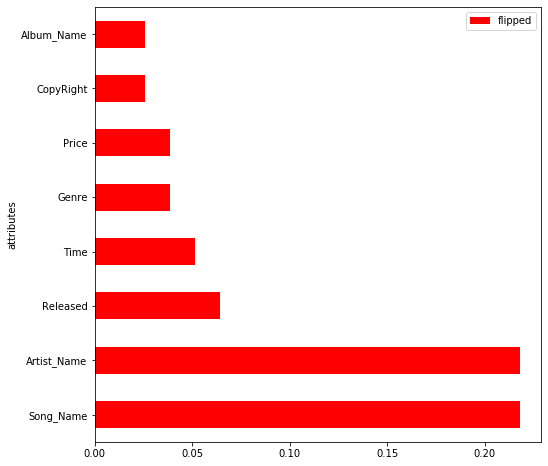

In [37]:
ax,negRank1  = aggregateRankings(neg_rankings_itunes1,positive=False,maxLenAttributes=1,lenTriangles=78)

In [38]:
pos_rankings_itunes1,flipped_pos1 = explainer_retrained1.getRankingsBlackBox(DATASET_DIR,'augmented_test.csv',
                                                                             1,1,augment_test=True)



  0%|          | 0/78 [00:00<?, ?it/s]

  1%|▏         | 1/78 [00:01<01:35,  1.24s/it]

  3%|▎         | 2/78 [00:02<01:33,  1.23s/it]

  4%|▍         | 3/78 [00:03<01:30,  1.21s/it]

  5%|▌         | 4/78 [00:04<01:28,  1.19s/it]

  6%|▋         | 5/78 [00:05<01:26,  1.18s/it]

  8%|▊         | 6/78 [00:07<01:24,  1.18s/it]

  9%|▉         | 7/78 [00:08<01:24,  1.19s/it]

 10%|█         | 8/78 [00:09<01:23,  1.19s/it]

 12%|█▏        | 9/78 [00:10<01:21,  1.18s/it]

 13%|█▎        | 10/78 [00:11<01:19,  1.17s/it]

 14%|█▍        | 11/78 [00:13<01:21,  1.22s/it]

 15%|█▌        | 12/78 [00:14<01:22,  1.25s/it]

 17%|█▋        | 13/78 [00:15<01:19,  1.22s/it]

 18%|█▊        | 14/78 [00:16<01:15,  1.19s/it]

 19%|█▉        | 15/78 [00:17<01:13,  1.17s/it]

 21%|██        | 16/78 [00:18<01:11,  1.15s/it]

 22%|██▏       | 17/78 [00:20<01:09,  1.14s/it]

 23%|██▎       | 18/78 [00:21<01:09,  1.15s/it]

 24%|██▍       | 19/78 [00:22<01:14,  1.26s/it]

 26%|██▌       | 20/78 [00:23<01:12,

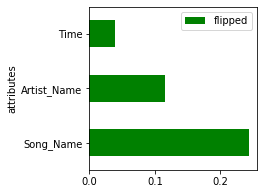

In [39]:
ax,posRank1 = aggregateRankings(pos_rankings_itunes1,positive=True,maxLenAttributes=1,lenTriangles=78)

## Prepare second retrain

In [139]:
train,validation,test = dm.data.process(ITUNES_DIR,train='improvedTrain2.csv',validation='valid_withid.csv',
                                       test='test_withid.csv',left_prefix='ltable_',right_prefix='rtable_',
                                        cache='impr2.pth',ignore_columns=['ltable_id','rtable_id'])


Reading and processing data from "datasets/Structured/itunes-amazon/improvedTrain2.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/itunes-amazon/valid_withid.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/itunes-amazon/test_withid.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [141]:
retrained2 = dm.MatchingModel(attr_summarizer='hybrid')
retrained2.run_train(train,validation,pos_neg_ratio=4,
                      batch_size=16,epochs=25,best_save_path='itunesamazon_impr2.pth')

* Number of trainable parameters: 17757810
===>  TRAIN Epoch 1


/home/nvidia/anaconda3/envs/torchenv/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 1 || Run Time:   12.1 | Load Time:    2.5 || F1:  45.08 | Prec:  30.38 | Rec:  87.29 || Ex/s:  29.77

===>  EVAL Epoch 1


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 1 || Run Time:    1.1 | Load Time:    0.5 || F1:  50.00 | Prec:  33.77 | Rec:  96.30 || Ex/s:  69.38

* Best F1: tensor(50.0000, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 2 || Run Time:   12.4 | Load Time:    2.6 || F1:  60.56 | Prec:  45.04 | Rec:  92.37 || Ex/s:  29.06

===>  EVAL Epoch 2


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 2 || Run Time:    1.0 | Load Time:    0.5 || F1:  55.10 | Prec:  38.03 | Rec: 100.00 || Ex/s:  71.33

* Best F1: tensor(55.1020, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 3 || Run Time:   12.5 | Load Time:    2.6 || F1:  76.32 | Prec:  62.37 | Rec:  98.31 || Ex/s:  28.72

===>  EVAL Epoch 3


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 3 || Run Time:    1.0 | Load Time:    0.5 || F1:  71.88 | Prec:  62.16 | Rec:  85.19 || Ex/s:  70.13

* Best F1: tensor(71.8750, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 4


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 4 || Run Time:   12.4 | Load Time:    2.6 || F1:  92.19 | Prec:  85.51 | Rec: 100.00 || Ex/s:  29.03

===>  EVAL Epoch 4


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 4 || Run Time:    1.0 | Load Time:    0.5 || F1:  79.31 | Prec:  74.19 | Rec:  85.19 || Ex/s:  70.66

* Best F1: tensor(79.3103, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 5


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 5 || Run Time:   12.5 | Load Time:    2.7 || F1:  99.16 | Prec:  98.33 | Rec: 100.00 || Ex/s:  28.72

===>  EVAL Epoch 5


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 5 || Run Time:    1.0 | Load Time:    0.5 || F1:  77.14 | Prec:  62.79 | Rec: 100.00 || Ex/s:  72.08

---------------------

===>  TRAIN Epoch 6


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 6 || Run Time:   12.4 | Load Time:    2.6 || F1:  97.93 | Prec:  95.93 | Rec: 100.00 || Ex/s:  29.10

===>  EVAL Epoch 6


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 6 || Run Time:    1.0 | Load Time:    0.5 || F1:  80.00 | Prec:  68.42 | Rec:  96.30 || Ex/s:  71.16

* Best F1: tensor(80., device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 7


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 7 || Run Time:   12.1 | Load Time:    2.5 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.72

===>  EVAL Epoch 7


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 7 || Run Time:    1.0 | Load Time:    0.5 || F1:  79.41 | Prec:  65.85 | Rec: 100.00 || Ex/s:  71.60

---------------------

===>  TRAIN Epoch 8


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 8 || Run Time:   12.3 | Load Time:    2.5 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.38

===>  EVAL Epoch 8


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 8 || Run Time:    1.0 | Load Time:    0.5 || F1:  80.60 | Prec:  67.50 | Rec: 100.00 || Ex/s:  72.03

* Best F1: tensor(80.5970, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 9


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 9 || Run Time:   12.2 | Load Time:    2.6 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.53

===>  EVAL Epoch 9


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 9 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  71.31

* Best F1: tensor(81.2500, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 10


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 10 || Run Time:   12.4 | Load Time:    2.6 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.23

===>  EVAL Epoch 10


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 10 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  72.24

---------------------

===>  TRAIN Epoch 11


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 11 || Run Time:   12.3 | Load Time:    2.5 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.48

===>  EVAL Epoch 11


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 11 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  72.29

---------------------

===>  TRAIN Epoch 12


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 12 || Run Time:   12.2 | Load Time:    2.5 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.60

===>  EVAL Epoch 12


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 12 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  72.14

---------------------

===>  TRAIN Epoch 13


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 13 || Run Time:   12.4 | Load Time:    2.6 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.01

===>  EVAL Epoch 13


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 13 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  72.32

---------------------

===>  TRAIN Epoch 14


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 14 || Run Time:   12.2 | Load Time:    2.5 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.52

===>  EVAL Epoch 14


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 14 || Run Time:    1.0 | Load Time:    0.5 || F1:  78.79 | Prec:  66.67 | Rec:  96.30 || Ex/s:  71.26

---------------------

===>  TRAIN Epoch 15


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 15 || Run Time:   12.4 | Load Time:    2.6 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.15

===>  EVAL Epoch 15


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 15 || Run Time:    1.0 | Load Time:    0.5 || F1:  78.79 | Prec:  66.67 | Rec:  96.30 || Ex/s:  72.04

---------------------

===>  TRAIN Epoch 16


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 16 || Run Time:   12.2 | Load Time:    2.5 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.62

===>  EVAL Epoch 16


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 16 || Run Time:    1.1 | Load Time:    0.5 || F1:  78.79 | Prec:  66.67 | Rec:  96.30 || Ex/s:  66.63

---------------------

===>  TRAIN Epoch 17


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 17 || Run Time:   12.1 | Load Time:    2.5 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.82

===>  EVAL Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 17 || Run Time:    1.0 | Load Time:    0.5 || F1:  78.79 | Prec:  66.67 | Rec:  96.30 || Ex/s:  71.01

---------------------

===>  TRAIN Epoch 18


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 18 || Run Time:   11.8 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  30.88

===>  EVAL Epoch 18


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 18 || Run Time:    1.0 | Load Time:    0.5 || F1:  78.79 | Prec:  66.67 | Rec:  96.30 || Ex/s:  71.80

---------------------

===>  TRAIN Epoch 19


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 19 || Run Time:   12.4 | Load Time:    2.5 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.24

===>  EVAL Epoch 19


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 19 || Run Time:    1.0 | Load Time:    0.5 || F1:  78.79 | Prec:  66.67 | Rec:  96.30 || Ex/s:  71.28

---------------------

===>  TRAIN Epoch 20


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 20 || Run Time:   12.3 | Load Time:    2.5 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.36

===>  EVAL Epoch 20


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 20 || Run Time:    1.0 | Load Time:    0.5 || F1:  78.79 | Prec:  66.67 | Rec:  96.30 || Ex/s:  71.53

---------------------

===>  TRAIN Epoch 21


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 21 || Run Time:   12.3 | Load Time:    2.5 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.40

===>  EVAL Epoch 21


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 21 || Run Time:    1.0 | Load Time:    0.5 || F1:  78.79 | Prec:  66.67 | Rec:  96.30 || Ex/s:  71.98

---------------------

===>  TRAIN Epoch 22


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 22 || Run Time:   12.2 | Load Time:    2.5 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.55

===>  EVAL Epoch 22


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 22 || Run Time:    1.0 | Load Time:    0.5 || F1:  78.79 | Prec:  66.67 | Rec:  96.30 || Ex/s:  71.35

---------------------

===>  TRAIN Epoch 23


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 23 || Run Time:   12.2 | Load Time:    2.5 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.65

===>  EVAL Epoch 23


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 23 || Run Time:    1.0 | Load Time:    0.5 || F1:  78.79 | Prec:  66.67 | Rec:  96.30 || Ex/s:  71.92

---------------------

===>  TRAIN Epoch 24


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 24 || Run Time:   12.4 | Load Time:    2.6 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.02

===>  EVAL Epoch 24


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 24 || Run Time:    1.0 | Load Time:    0.5 || F1:  78.79 | Prec:  66.67 | Rec:  96.30 || Ex/s:  71.46

---------------------

===>  TRAIN Epoch 25


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 25 || Run Time:   12.2 | Load Time:    2.5 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.62

===>  EVAL Epoch 25


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 25 || Run Time:    1.0 | Load Time:    0.5 || F1:  78.79 | Prec:  66.67 | Rec:  96.30 || Ex/s:  71.28

---------------------

Loading best model...
Training done.


tensor(81.2500, device='cuda:0')

In [142]:
retrained2.run_eval(test)

===>  EVAL Epoch 9
Finished Epoch 9 || Run Time:    0.6 | Load Time:    0.6 || F1:  85.71 | Prec:  82.76 | Rec:  88.89 || Ex/s:  94.43



tensor(85.7143, device='cuda:0')

### Evaluate second retrain

In [41]:
retrained2 = dm.MatchingModel(attr_summarizer='hybrid')
retrained2.load_state('models/itunesamazon_impr2.pth')
retrained2 = retrained2.to('cuda')

In [42]:
explainer_retrained2 = Explainer(retrained2,[])

In [43]:
neg_rankings_itunes2,flippedPredictions_neg2 = explainer_retrained2.getRankingsBlackBox(DATASET_DIR,'augmented_test.csv',
                                                                                       0,1,augment_test=True)



  0%|          | 0/79 [00:00<?, ?it/s]

  1%|▏         | 1/79 [00:01<01:28,  1.13s/it]

  3%|▎         | 2/79 [00:02<01:26,  1.13s/it]

  4%|▍         | 3/79 [00:03<01:25,  1.13s/it]

  5%|▌         | 4/79 [00:04<01:25,  1.15s/it]

  6%|▋         | 5/79 [00:05<01:24,  1.14s/it]

  8%|▊         | 6/79 [00:06<01:23,  1.14s/it]

  9%|▉         | 7/79 [00:07<01:22,  1.14s/it]

 10%|█         | 8/79 [00:09<01:21,  1.15s/it]

 11%|█▏        | 9/79 [00:10<01:20,  1.15s/it]

 13%|█▎        | 10/79 [00:11<01:19,  1.16s/it]

 14%|█▍        | 11/79 [00:12<01:18,  1.15s/it]

 15%|█▌        | 12/79 [00:13<01:17,  1.16s/it]

 16%|█▋        | 13/79 [00:14<01:16,  1.16s/it]

 18%|█▊        | 14/79 [00:16<01:15,  1.16s/it]

 19%|█▉        | 15/79 [00:17<01:14,  1.16s/it]

 20%|██        | 16/79 [00:18<01:14,  1.18s/it]

 22%|██▏       | 17/79 [00:19<01:12,  1.18s/it]

 23%|██▎       | 18/79 [00:20<01:11,  1.17s/it]

 24%|██▍       | 19/79 [00:22<01:10,  1.18s/it]

 25%|██▌       | 20/79 [00:23<01:09,

In [44]:
pos_rankings_itunes2,flipped_pos2 = explainer_retrained2.getRankingsBlackBox(DATASET_DIR,'augmented_test.csv',
                                                                            1,1,augment_test=True)



  0%|          | 0/79 [00:00<?, ?it/s]

  1%|▏         | 1/79 [00:01<01:29,  1.15s/it]

  3%|▎         | 2/79 [00:02<01:28,  1.15s/it]

  4%|▍         | 3/79 [00:03<01:27,  1.15s/it]

  5%|▌         | 4/79 [00:04<01:27,  1.17s/it]

  6%|▋         | 5/79 [00:05<01:26,  1.17s/it]

  8%|▊         | 6/79 [00:06<01:24,  1.16s/it]

  9%|▉         | 7/79 [00:08<01:23,  1.16s/it]

 10%|█         | 8/79 [00:09<01:22,  1.16s/it]

 11%|█▏        | 9/79 [00:10<01:21,  1.16s/it]

 13%|█▎        | 10/79 [00:11<01:21,  1.18s/it]

 14%|█▍        | 11/79 [00:12<01:19,  1.17s/it]

 15%|█▌        | 12/79 [00:13<01:17,  1.16s/it]

 16%|█▋        | 13/79 [00:15<01:16,  1.16s/it]

 18%|█▊        | 14/79 [00:16<01:15,  1.16s/it]

 19%|█▉        | 15/79 [00:17<01:14,  1.16s/it]

 20%|██        | 16/79 [00:18<01:13,  1.17s/it]

 22%|██▏       | 17/79 [00:19<01:12,  1.17s/it]

 23%|██▎       | 18/79 [00:20<01:11,  1.18s/it]

 24%|██▍       | 19/79 [00:22<01:10,  1.18s/it]

 25%|██▌       | 20/79 [00:23<01:09,

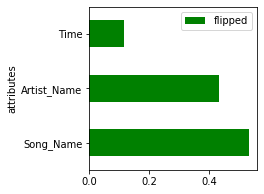

In [45]:
ax,posRank2 = aggregateRankings(pos_rankings_itunes2,positive=True,maxLenAttributes=1,lenTriangles=79)

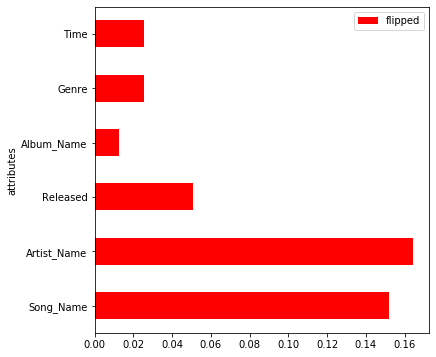

In [46]:
ax,negRank2 = aggregateRankings(neg_rankings_itunes2,positive=False,maxLenAttributes=1,lenTriangles=79)

In [48]:
def fillRankings(rank_s,attributes):
    s3 = {}
    for att in attributes:
        if (att,) not in rank_s.index:
            s3[att] = 0
        else:
            s3[att] = rank_s[(att,)]
    return pd.Series(s3)

In [49]:
attributes = attributes = ['Song_Name','Artist_Name','Album_Name','Genre','Price','CopyRight','Time','Released']

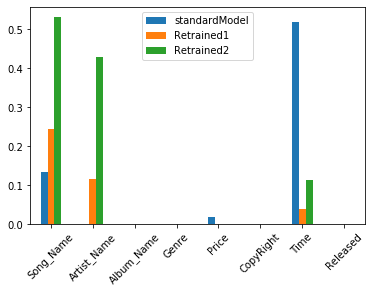

In [55]:
pr0 = fillRankings(pd.Series(posRank0),attributes)
pr1 = fillRankings(pd.Series(posRank1),attributes)
pr2 = fillRankings(pd.Series(posRank2),attributes)
pos_df = pd.DataFrame({'standardModel': pr0.values,
                   'Retrained1': pr1.values,'Retrained2':pr2.values}, index=attributes)
pos_comparison = pos_df.plot.bar(rot=45)

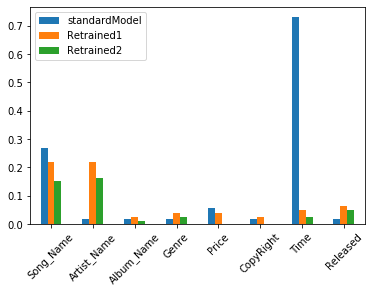

In [56]:
nr0 = fillRankings(pd.Series(negRank0),attributes)
nr1 = fillRankings(pd.Series(negRank1),attributes)
nr2 = fillRankings(pd.Series(negRank2),attributes)
neg_df = pd.DataFrame({'standardModel': nr0.values,
                   'Retrained1': nr1.values,'Retrained2':nr2.values}, index=attributes)
neg_comparison = neg_df.plot.bar(rot=45)

In [59]:
pos_fig = pos_comparison.get_figure()
pos_fig.savefig(fname='pos_comparison.pdf',bbox_inches='tight')

In [60]:
neg_fig = neg_comparison.get_figure()
neg_fig.savefig(fname='neg_comparison.pdf',bbox_inches='tight')

In [42]:
originalTest = pd.read_csv(ITUNES_DIR+'merged_test.csv')
c0,cv0 = getMeanConfidenceAndVariance(itunes_model,originalTest)
c1,cv1 = getMeanConfidenceAndVariance(retrained1,originalTest)
c2,cv2 = getMeanConfidenceAndVariance(retrained2,originalTest)

In [43]:
c0,c1,c2

(0.8026398884457185, 0.7903955578804016, 0.8272332293451379)

In [44]:
cv0,cv1,cv2

(0.014892625030903646, 0.011770060641655073, 0.01111070486279176)

## Analyze patterns in flipped predictions

In [58]:
flippedNegPredOnTime = flipped_neg0[flipped_neg0.alteredAttribute==('Time',)]
ltime0 = flippedNegPredOnTime.ltable_Time.values
rtime0 = flippedNegPredOnTime.rtable_Time.values

In [59]:
timeIsEqual = 0
for l,r in zip(ltime0,rtime0):
    if l==r :
        timeIsEqual +=1
timeIsEqual/len(ltime0)

0.9210526315789473

In [78]:
flippedNegOnArtist2 = flippedPredictions_neg2[
    flippedPredictions_neg2.alteredAttribute==('Artist_Name',)]
lartist2 = flippedNegOnArtist2.ltable_Artist_Name.values
rartist2 = flippedNegOnArtist2.rtable_Artist_Name.values

In [79]:
lartist2

array(['Jason Derulo', 'Mark Ronson', 'Mark Ronson', 'Kenny Chesney',
       'Brett Eldredge', 'Brett Eldredge', 'Keith Urban', 'Keith Urban',
       'Fifth Harmony', 'Fifth Harmony', 'Luke Bryan', 'Luke Bryan',
       'One Direction'], dtype=object)

In [80]:
rartist2

array(['Jason Derulo', 'Mark Ronson', 'Mark Ronson', 'Kenny Chesney',
       'Brett Eldredge', 'Brett Eldredge', 'Keith Urban', 'Keith Urban',
       'Fifth Harmony', 'Fifth Harmony', 'Luke Bryan', 'Luke Bryan',
       'One Direction'], dtype=object)

In [81]:
flippedNegOnArtist0 = flipped_neg0[
    flipped_neg0.alteredAttribute==('Song_Name',)]
lartist0 = flippedNegOnArtist0.ltable_Song_Name.values
rartist0 = flippedNegOnArtist0.rtable_Song_Name.values

In [82]:
lartist0

array(['45', 'X2CU', 'Over My Dead Body [ Clean ]',
       'Latch [ feat . Sam Smith ]', 'Cameras', 'Cameras [ Clean ]',
       'Outversion', 'Yayo', 'You Gon na Fly', 'Billy', 'Billy',
       'Whateva ( feat . Monty ) [ Explicit ]',
       'Whateva ( feat . Monty ) [ Explicit ]', 'Better Than Words'],
      dtype=object)

In [83]:
rartist0

array(['45', 'X2CU', 'Over My Dead Body', 'Latch ( feat . Sam Smith )',
       'Cameras [ Clean ]', 'Cameras', 'Outversion', 'Yayo',
       'You Gon na Fly', 'Billy', 'Billy', 'Whateva ( feat . Monty )',
       'Whateva ( feat . Monty )', 'Better Than Words'], dtype=object)

In [59]:
flippedPosOnArtist2 = flippedPredictions_pos2[
    flippedPredictions_pos2.alteredAttribute==('Artist_Name',)]
plartist2 = flippedPosOnArtist2.ltable_Artist_Name.values
prartist2 = flippedPosOnArtist2.rtable_Artist_Name.values

In [60]:
plartist2

array(['Jason Derulo', 'Drake', 'Flo Rida', 'Howard Shore',
       'Fifth Harmony', 'Fifth Harmony', 'Keith Urban', 'P!nk',
       'Fetty Wap', 'One Direction', 'Jason Derulo', 'Drake', 'Flo Rida',
       'Howard Shore', 'Fifth Harmony', 'Fifth Harmony', 'Keith Urban',
       'P!nk', 'Fetty Wap', 'One Direction'], dtype=object)

In [61]:
prartist2

array(['Flo Rida', 'Florida Georgia Line', 'Jason Derulo', 'Wiz Khalifa',
       'Wiz Khalifa', 'One Direction', 'Disclosure', 'Brett Eldredge',
       'Kenny Chesney', 'Zedd', 'Flo Rida', 'Florida Georgia Line',
       'Jason Derulo', 'Wiz Khalifa', 'Wiz Khalifa', 'One Direction',
       'Disclosure', 'Brett Eldredge', 'Kenny Chesney', 'Zedd'],
      dtype=object)

## Create benchmark test-set

In [93]:
flipped_neg0['label'] = 0
flippedPredictions_pos0['label'] = 1
##flipped_neg0 = flipped_neg0.drop(columns=['ltable_id','rtable_id'],axis=1)
##flippedPredictions_pos0 = flippedPredictions_pos0.drop(columns=['ltable_id','rtable_id'],axis=1)
benchmarkDataset = pd.concat([flipped_neg0,flippedPredictions_pos0])
benchmarkDataset['id'] = np.arange(len(benchmarkDataset))
benchmarkDataset.to_csv('itunes_amazon_retrain_test.csv',index=False)

In [99]:
subset = benchmarkDataset.iloc[0:5]
subset.at[0,'label'] = 1

In [101]:
n = input("What is your name? ")
print("Hello,", n+"!")

What is your name? vincenzo
Hello, vincenzo!


In [121]:
benchmarkDataset = benchmarkDataset.reset_index()

In [123]:
for i in range(70,len(benchmarkDataset)):
    display(benchmarkDataset.iloc[[i]])
    label = input('label ?')
    benchmarkDataset.at[i,'label'] = label

,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
70,10,I Know [ feat . Wiz Khalifa ] [ Explicit ],Diddy - Dirty Money,Last Train To Paris [ Explicit ],Rap & Hip-Hop,$ 1.29,( C ) 2010 Bad Boy/Interscope Records,4:31,"December 14 , 2010","I Know ( feat . Chris Brown , Wiz Khalifa & Se...","Diddy - Dirty Money , Chris Brown , Wiz Khalif...",Last Train to Paris,"Hip-Hop/Rap , Music , R&B / Soul , Contemporar...",$ 1.29,‰ ãÑ 2010 Bad Boy/Interscope Records,2:57,14-Dec-10,70,"(Time,)",1


label ?1


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
71,11,I Know [ feat . Wiz Khalifa ] [ Explicit ],Diddy - Dirty Money,Last Train To Paris [ Explicit ],Rap & Hip-Hop,$ 1.29,( C ) 2010 Bad Boy/Interscope Records,4:31,"December 14 , 2010","I Know ( feat . Chris Brown , Wiz Khalifa & Se...","Diddy - Dirty Money , Chris Brown , Wiz Khalif...",Last Train to Paris,"Hip-Hop/Rap , Music , R&B / Soul , Contemporar...",$ 1.29,‰ ãÑ 2010 Bad Boy/Interscope Records,5:06,14-Dec-10,71,"(Time,)",1


label ?1


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
72,12,My Armor Is Iron,Howard Shore,The Hobbit : The Desolation of Smaug ( Origina...,"Soundtrack , Music , Soundtrack , Classical , ...",$ 1.29,‰ ãÑ 2013 WaterTower Music,5:16,10-Dec-13,My Armor Is Iron,Howard Shore,The Hobbit : The Desolation of Smaug ( Origina...,Soundtracks,$ 1.29,2013 WaterTower Music / Warner Bros. . Enterta...,2:48,"December 10 , 2013",72,"(Time,)",1


label ?1


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
73,13,My Armor Is Iron,Howard Shore,The Hobbit : The Desolation of Smaug ( Origina...,Soundtracks,$ 1.29,2013 WaterTower Music / Warner Bros. . Enterta...,5:16,"December 10 , 2013",Street Money ( feat . Rick Ross ) [ Explicit ],Howard Shore,The Hobbit : The Desolation of Smaug ( Origina...,"Soundtrack , Music , Soundtrack , Classical , ...",$ 1.29,‰ ãÑ 2013 WaterTower Music,5:16,10-Dec-13,73,"(Song_Name,)",0


label ?0


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
74,14,My Armor Is Iron,Howard Shore,The Hobbit : The Desolation of Smaug ( Origina...,Soundtracks,$ 1.29,2013 WaterTower Music / Warner Bros. . Enterta...,5:16,"December 10 , 2013",My Armor Is Iron,Howard Shore,The Hobbit : The Desolation of Smaug ( Origina...,"Soundtrack , Music , Soundtrack , Classical , ...",$ 1.29,‰ ãÑ 2013 WaterTower Music,3:47,10-Dec-13,74,"(Time,)",1


label ?1


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
75,15,Going Away For A While,Brett Eldredge,Illinois,Country,$ 1.29,( c ) Phonotype,3:15,"September 11 , 2015",All Me [ feat . 2 Chainz ] [ Explicit ],Brett Eldredge,Illinois,"Country , Music , Contemporary Country , Honky...",$ 1.29,2015 Atlantic Recording Corporation for the Un...,3:13,11-Sep-15,75,"(Song_Name,)",0


label ?0


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
76,16,Going Away For A While,Brett Eldredge,Illinois,Country,$ 1.29,( c ) Phonotype,3:15,"September 11 , 2015",Going Away For a While,Brett Eldredge,Illinois,"Country , Music , Contemporary Country , Honky...",$ 1.29,2015 Atlantic Recording Corporation for the Un...,3:47,11-Sep-15,76,"(Time,)",1


label ?1


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
77,17,Brave Honest Beautiful ( feat . Meghan Trainor ),Fifth Harmony,Reflection ( Deluxe ),"Pop , Music , R&B / Soul , Dance , Teen Pop , ...",$ 1.29,"2014 , 2015 Simco Ltd. under exclusive license...",3:28,30-Jan-15,Brave Honest Beautiful,Fifth Harmony,Reflection ( Deluxe ),Pop,$ 1.29,"( C ) 2012 Big Machine Records , LLC .",4:31,"January 30 , 2015",77,"(Time,)",1


label ?1


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
78,18,Brave Honest Beautiful,Fifth Harmony,Reflection ( Deluxe ),Pop,$ 1.29,"( C ) 2012 Big Machine Records , LLC .",3:28,"January 30 , 2015",You & Me [ feat . Eliza Doolittle ],Fifth Harmony,Reflection ( Deluxe ),"Pop , Music , R&B / Soul , Dance , Teen Pop , ...",$ 1.29,"2014 , 2015 Simco Ltd. under exclusive license...",3:28,30-Jan-15,78,"(Song_Name,)",0


label ?0


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
79,19,Brave Honest Beautiful,Fifth Harmony,Reflection ( Deluxe ),Pop,$ 1.29,"( C ) 2012 Big Machine Records , LLC .",3:28,"January 30 , 2015",Brave Honest Beautiful ( feat . Meghan Trainor ),Fifth Harmony,Reflection ( Deluxe ),"Pop , Music , R&B / Soul , Dance , Teen Pop , ...",$ 1.29,"2014 , 2015 Simco Ltd. under exclusive license...",4:27,30-Jan-15,79,"(Time,)",1


label ?1


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
80,20,Brave Honest Beautiful,Fifth Harmony,Reflection ( Deluxe ),Pop,$ 1.29,"( C ) 2012 Big Machine Records , LLC .",3:28,"January 30 , 2015",Cameras [ Clean ],Fifth Harmony,Reflection ( Deluxe ),"Pop , Music , R&B / Soul , Dance , Teen Pop , ...",$ 1.29,"2014 , 2015 Simco Ltd. under exclusive license...",3:28,30-Jan-15,80,"(Song_Name,)",0


label ?0


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
81,21,Brave Honest Beautiful,Fifth Harmony,Reflection ( Deluxe ),Pop,$ 1.29,"( C ) 2012 Big Machine Records , LLC .",3:28,"January 30 , 2015",Brave Honest Beautiful ( feat . Meghan Trainor ),Fifth Harmony,Reflection ( Deluxe ),"Pop , Music , R&B / Soul , Dance , Teen Pop , ...",$ 1.29,"2014 , 2015 Simco Ltd. under exclusive license...",4:29,30-Jan-15,81,"(Time,)",1


label ?1


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
82,22,You Gon na Fly,Keith Urban,Get Closer ( Deluxe Version ),Country,$ 1.29,( C ) 2011 Hit Red Records under exclusive lic...,3:36,"February 22 , 2011",Still Pimpin ' ( Album Version ( Explicit ) ) ...,Keith Urban,Get Closer ( Deluxe Version ),"Country , Music , Honky Tonk , Pop , Pop/Rock ...",$ 1.29,‰ ãÑ 2010 Hit Red Records under exclusive lice...,3:36,22-Feb-11,82,"(Song_Name,)",0


label ?0


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
83,23,I Have Seen The Rain ( Featuring James T. Moor...,P!nk,I 'm Not Dead [ Explicit ],"Dance & Electronic , Pop , R&B",$ 0.99,"( C ) 2009 Foo & Blu , LLC under exclusive Lic...",3:29,"April 4 , 2006",I Have Seen the Rain ( Featuring James T. Moore ),P!nk featuring James T. Moore,I 'm Not Dead,"Pop , Music , Electronic , R&B / Soul , Pop/Ro...",$ 0.99,"2006 RCA/JIVE Label Group , a unit of Sony Mus...",3:47,4-Mar-06,83,"(Time,)",0


label ?1


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
84,24,Whateva ( feat . Monty ),Fetty Wap,Fetty Wap ( Deluxe ),"Hip-Hop/Rap , Music , Rap",Album Only,2015 300 Entertainment/RGF Productions,5:11,NaN,Whateva ( feat . Monty ) [ Explicit ],Fetty Wap,Fetty Wap ( Deluxe ) [ Explicit ],Rap & Hip-Hop,$ 1.29,"( C ) 2000 Mute Records Ltd. , a BMG Company ,...",4:32,"September 25 , 2015",84,"(Time,)",0


label ?1


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
85,25,Whateva ( feat . Monty ) [ Explicit ],Fetty Wap,Fetty Wap ( Deluxe ) [ Explicit ],Rap & Hip-Hop,$ 1.29,"( C ) 2000 Mute Records Ltd. , a BMG Company ,...",5:11,"September 25 , 2015",No Money no Love ( feat . Elliphant & Ms. Dyna...,Fetty Wap,Fetty Wap ( Deluxe ),"Hip-Hop/Rap , Music , Rap",Album Only,2015 300 Entertainment/RGF Productions,5:11,NaN,85,"(Song_Name,)",0


label ?0


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
86,26,Whateva ( feat . Monty ) [ Explicit ],Fetty Wap,Fetty Wap ( Deluxe ) [ Explicit ],Rap & Hip-Hop,$ 1.29,"( C ) 2000 Mute Records Ltd. , a BMG Company ,...",5:11,"September 25 , 2015",Whateva ( feat . Monty ),Fetty Wap,Fetty Wap ( Deluxe ),"Hip-Hop/Rap , Music , Rap",Album Only,2015 300 Entertainment/RGF Productions,3:57,NaN,86,"(Time,)",0


label ?1


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
87,27,Whateva ( feat . Monty ) [ Explicit ],Fetty Wap,Fetty Wap ( Deluxe ) [ Explicit ],Rap & Hip-Hop,$ 1.29,"( C ) 2000 Mute Records Ltd. , a BMG Company ,...",5:11,"September 25 , 2015",Whateva ( feat . Monty ),Fetty Wap,Fetty Wap ( Deluxe ),"Hip-Hop/Rap , Music , Rap",Album Only,2015 300 Entertainment/RGF Productions,0:24,NaN,87,"(Time,)",0


label ?1


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
88,28,Whateva ( feat . Monty ) [ Explicit ],Fetty Wap,Fetty Wap ( Deluxe ) [ Explicit ],Rap & Hip-Hop,$ 1.29,"( C ) 2000 Mute Records Ltd. , a BMG Company ,...",5:11,"September 25 , 2015","We Dem Boyz Remix ( feat . Rick Ross , ScHoolb...",Fetty Wap,Fetty Wap ( Deluxe ),"Hip-Hop/Rap , Music , Rap",Album Only,2015 300 Entertainment/RGF Productions,5:11,NaN,88,"(Song_Name,)",0


label ?0


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
89,29,Whateva ( feat . Monty ) [ Explicit ],Fetty Wap,Fetty Wap ( Deluxe ) [ Explicit ],Rap & Hip-Hop,$ 1.29,"( C ) 2000 Mute Records Ltd. , a BMG Company ,...",5:11,"September 25 , 2015",Whateva ( feat . Monty ),Fetty Wap,Fetty Wap ( Deluxe ),"Hip-Hop/Rap , Music , Rap",Album Only,2015 300 Entertainment/RGF Productions,5:19,NaN,89,"(Time,)",0


label ?1


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
90,30,Through the Ghost,Shinedown,The Studio Album Collection,Rock,$ 1.29,2013 Atlantic Recording Corporation for the Un...,4:01,"November 8 , 2013",Through the Ghost,Shinedown,The Studio Album Collection,"Rock , Music",$ 1.29,2013 Atlantic Recording Corporation for the Un...,3:23,8-Nov-13,90,"(Time,)",0


label ?1


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
91,31,Through the Ghost,Shinedown,The Studio Album Collection,Rock,$ 1.29,2013 Atlantic Recording Corporation for the Un...,4:01,"November 8 , 2013",Through the Ghost,Shinedown,The Studio Album Collection,"Rock , Music",$ 1.29,2013 Atlantic Recording Corporation for the Un...,0:11,8-Nov-13,91,"(Time,)",0


label ?1


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
92,32,We Know,Fifth Harmony,Reflection,"Pop , Music , R&B / Soul , Teen Pop , Dance , ...",$ 1.29,"2014 , 2015 Simco Ltd. under exclusive license...",2:57,30-Jan-15,We Know,Fifth Harmony,Reflection,Pop,$ 1.29,"( C ) 2012 Big Machine Records , LLC .",4:31,"January 30 , 2015",92,"(Time,)",0


label ?1


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
93,33,We Know,Fifth Harmony,Reflection,Pop,$ 1.29,"( C ) 2012 Big Machine Records , LLC .",2:57,"January 30 , 2015",We Know,Fifth Harmony,Reflection,"Pop , Music , R&B / Soul , Teen Pop , Dance , ...",$ 1.29,"2014 , 2015 Simco Ltd. under exclusive license...",4:01,30-Jan-15,93,"(Time,)",0


label ?1


,index,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id,alteredAttribute,label
94,34,Are You Leaving With Him,Luke Bryan,Spring Break ... Checkin ' Out,Country,$ 1.29,( C ) 2015 Capitol Records Nashville,3:24,"March 10 , 2015",Are You Leaving With Him,Luke Bryan,Spring Break ... Checkin ' Out,"Country , Music , Contemporary Country",$ 1.29,2015 Capitol Records Nashville,3:46,10-Mar-15,94,"(Time,)",0


label ?1


In [124]:
benchmarkDataset.to_csv('itunes_amazon_retrain_test.csv',index=False)

## Test on benchmark dataset

In [128]:
getF1PrecisionRecall(benchmarkDataset.label.values,wrapDm(benchmarkDataset,itunes_model,
                                                          ignore_columns=['alteredAttribute','label']))

(0.11111111111111112, 0.08196721311475409, 0.1724137931034483)

In [129]:
getF1PrecisionRecall(benchmarkDataset.label.values,wrapDm(benchmarkDataset,retrained1,
                                                          ignore_columns=['alteredAttribute','label']))

(0.5937499999999999, 0.5428571428571428, 0.6551724137931034)

In [130]:
getF1PrecisionRecall(benchmarkDataset.label.values,wrapDm(benchmarkDataset,retrained2,
                                                          ignore_columns=['alteredAttribute','label']))

(0.7142857142857143, 0.7407407407407407, 0.6896551724137931)

In [136]:
test_df = pd.read_csv(ITUNES_DIR+'merged_test.csv')
getF1PrecisionRecall(test_df.label.values,wrapDm(test_df,itunes_model,
                                                          ignore_columns=['label','id']))

(0.7999999999999999, 0.7272727272727273, 0.8888888888888888)

In [137]:
getF1PrecisionRecall(test_df.label.values,wrapDm(test_df,retrained1,
                                                          ignore_columns=['label','id']))

(0.8620689655172414, 0.8064516129032258, 0.9259259259259259)

In [138]:
getF1PrecisionRecall(test_df.label.values,wrapDm(test_df,retrained2,
                                                          ignore_columns=['label','id']))

(0.8571428571428572, 0.8275862068965517, 0.8888888888888888)

In [141]:
getMeanConfidenceAndVariance(itunes_model,test_df)

(0.8026398884457185, 0.014892625030903646)

In [142]:
getMeanConfidenceAndVariance(retrained1,test_df)

(0.7903955578804016, 0.011770060641655073)

In [143]:
getMeanConfidenceAndVariance(retrained1,test_df)

(0.7903955578804016, 0.011770060641655073)